# TRABAJO GRUPAL ANÁLISIS MULTIVARIANTE
### Global poverty and inequality dataset

**Kaggle link**: https://www.kaggle.com/datasets/utkarshx27/global-poverty-and-inequality-dataset/data?select=pip_codebook.csv

Mapa del mundo coloreable: https://naturaldisasters.ai/posts/python-geopandas-world-map-tutorial/

Artículo acerca de las asimétricas en métricas de desigualdad: https://academic.oup.com/jrssig/article/11/1/10/7028923?login=false

### Tabla de Contenidos: <a class="anchor" id="index"></a>

<div class="alert" style="margin-top: 20px">

1. [Cargar datos e importar librerías](#seccion_1)<br>

2. [Análisis descriptivo por subrgupos y transformación de variables](#seccion_2)<br>

3. [Análisis e imputación de datos perdidos](#seccion_3)<br>

4. [Análisis de correlaciones y reducción de la dimensionalidad](#seccion_4)<br>

5. [Análisis cluster](#seccion_5)<br>
</div>


### 1. Cargar datos e importar librerías <a class="anchor" id="seccion_1"></a>



In [241]:
# py -m pip install pandas
# py -m pip install numpy
# py -m pip install matplotlib
# py -m pip install plotly
# py -m pip install seaborn

In [242]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import plotly.graph_objects as go
import plotly.subplots as sp
from scipy.stats import zscore, f, boxcox, skew, shapiro

import seaborn as sns

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.exceptions import ConvergenceWarning

from continents import continent_dict 
from handleData import handleData

In [243]:
# Load the  dataset
file_name = 'pip_dataset.csv'
data = pd.read_csv( file_name)

# Create continent column
data['continent'] = data['country'].map(continent_dict) # create column continet
data = data[['country', 'continent'] + [col for col in data.columns if col not in ['country', 'continent']]]
data.head()

country continent  year reporting_level welfare_type  ppp_version  \
0  Albania    Europe  1996        national  consumption         2011   
1  Albania    Europe  2002        national  consumption         2011   
2  Albania    Europe  2005        national  consumption         2011   
3  Albania    Europe  2008        national  consumption         2011   
4  Albania    Europe  2012        national  consumption         2011   

   survey_year  survey_comparability  headcount_ratio_international_povline  \
0       1996.0                   0.0                               0.920669   
1       2002.0                   1.0                               1.570843   
2       2005.0                   1.0                               0.860527   
3       2008.0                   1.0                               0.313650   
4       2012.0                   1.0                               0.849754   

   headcount_ratio_lower_mid_income_povline  ...  decile8_thr  decile9_thr  \
0                                 11.174149  ...         8.85        10.92   
1                                 14.132118  ...         8.83        11.58   
2                                  8.715685  ...        10.02        12.78   
3                                  5.250542  ...        10.74        13.62   
4                                  6.182414  ...        10.52        13.26   

       gini       mld  polarization  palma_ratio  s80_s20_ratio  \
0  0.270103  0.119104      0.241293     0.928335       3.945872   
1  0.317390  0.164812      0.268982     1.215056       4.831625   
2  0.305957  0.154413      0.254529     1.142718       4.662236   
3  0.299847  0.148893      0.247311     1.114657       4.395911   
4  0.289605  0.138417      0.249988     1.041193       4.272573   

   p90_p10_ratio  p90_p50_ratio  p50_p10_ratio  
0       3.568627       1.889273       1.888889  
1       3.979381       2.090253       1.903780  
2       3.872727       1.978328       1.957576  
3       3.574803       1.956897       1.826772  
4       3.632877       1.941435       1.871233  

[5 rows x 109 columns]

Nos quedamos con la version de 2017, que tiene los datos ajustados a inflación, línea de pobreza, etcétera de ese año. Eliminamos el año de encuesta ya que coincide con survey year.

In [244]:
data = data[(data['ppp_version'] == 2017)]
data.drop(["survey_year","ppp_version"], axis= 1, inplace=True)

Observamos los diferentes niveles de reportes que se han hecho y concluimos que la variable no contiene suficiente información para el estudio. las encuestas de nivel rural y urbano tan solo tienen 63 y 118 instancias respectivamente y sin presencia en todos los continentes. Por tanto, mantener las instancias de tipo rural y urbano pueden introducir más ruido y variabilidad que información relevante.

In [245]:
for reporting_level in data['reporting_level'].value_counts().keys():
    data_level = data[(data['reporting_level'] == reporting_level )]
    print(f"\n{reporting_level.upper()}")
    print(data_level['continent'].value_counts())
    print(f"TOTAL INSTANCIAS = {data_level['continent'].value_counts().sum()}")


NATIONAL
continent
Europe     879
America    443
Asia       428
Africa     239
Oceania     35
Name: count, dtype: int64
TOTAL INSTANCIAS = 2024

URBAN
continent
Asia       61
America    56
Oceania     1
Name: count, dtype: int64
TOTAL INSTANCIAS = 118

RURAL
continent
Asia      61
Africa     2
Name: count, dtype: int64
TOTAL INSTANCIAS = 63


Procedemos a seleccionar tan solo las encuestas de tipo nacional y eliminamos la variable. Con esto eliminamos también todos aquellos territorios que son indeterminados y contienen una gran cantidad de NaN en sus filas (Worlwide, High income contries, Latin America and the Caribbean, ... ), ya que estos tampoco tienen establecido un nivel de reporte claro. Con esta pequeña selección reducimos enormemente la presencia de datos anómalos.

In [246]:
# Filtrar y mostrar los valores únicos de los países cuyo continente es NaN
territories_with_nan_continent = data[data['continent'].isna()]['country'].unique()

# Mostrar los resultados
print("Territorios con continente NaN:")
print(territories_with_nan_continent)

data = data[(data['reporting_level'] == 'national')]
data.drop("reporting_level", axis= 1, inplace=True)


Territorios con continente NaN:
['East Asia and Pacific' 'Europe and Central Asia' 'High income countries'
 'Latin America and the Caribbean' 'Middle East and North Africa'
 'South Asia' 'Sub-Saharan Africa' 'World']


Aprovechamos para agrupar variables numéricas y categóricas, y sustituir todos los valores de 0 por datos perdidos, ya que por la naturaleza de nuestras variables es imposible que tengan valor exactamente 0.

In [247]:
feat_names = data.columns
feat_cat = ['country', 'continent', 'welfare_type', 'survey_comparability']
feat_num = [feat for feat in feat_names if feat not in feat_cat]
data.iloc[:, 7:] = data.iloc[:, 7:].replace(0, np.nan)
data = data.reset_index(drop=True)

### 2. Análisis descriptivo por subrgupos y transformación de variables <a class="anchor" id="seccion_2"></a>
Para facilitar el análisis, creamos diferentes subgrupos de características según su categoría.


In [248]:
# Define subgroups
column_ranges = {
    'Headcount': (5, 27),
    'Average_Shortfall': (27, 38),
    'Total_Shortfall': (38, 49),
    'Income_Poverty_Gap': (49, 68),
    'Deciles': (68, 98),
    'Inequality_Metrics': (98, 107)
}

# Compress subgroups in a single dictionary
datasets = {name: data.iloc[:, start:end] for name, (start, end) in column_ranges.items()}

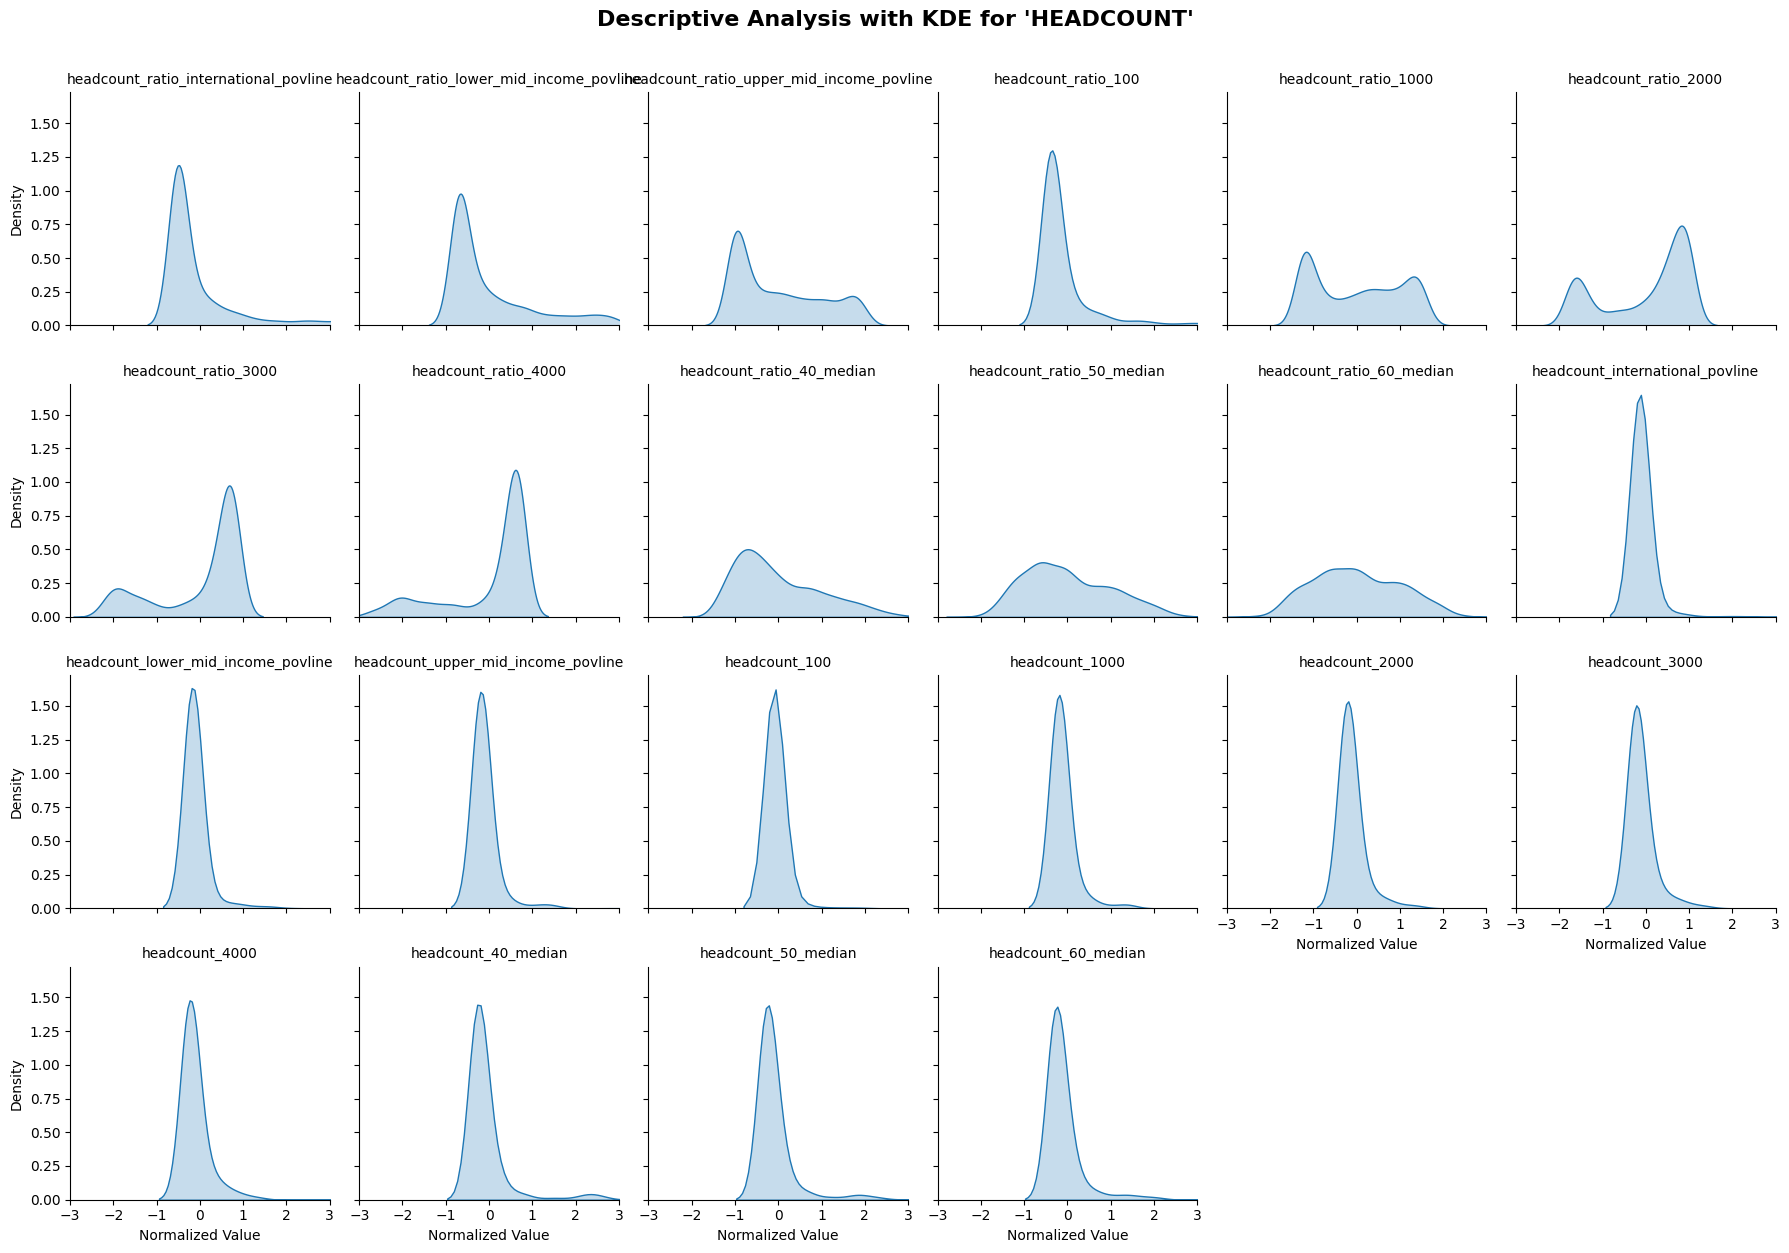

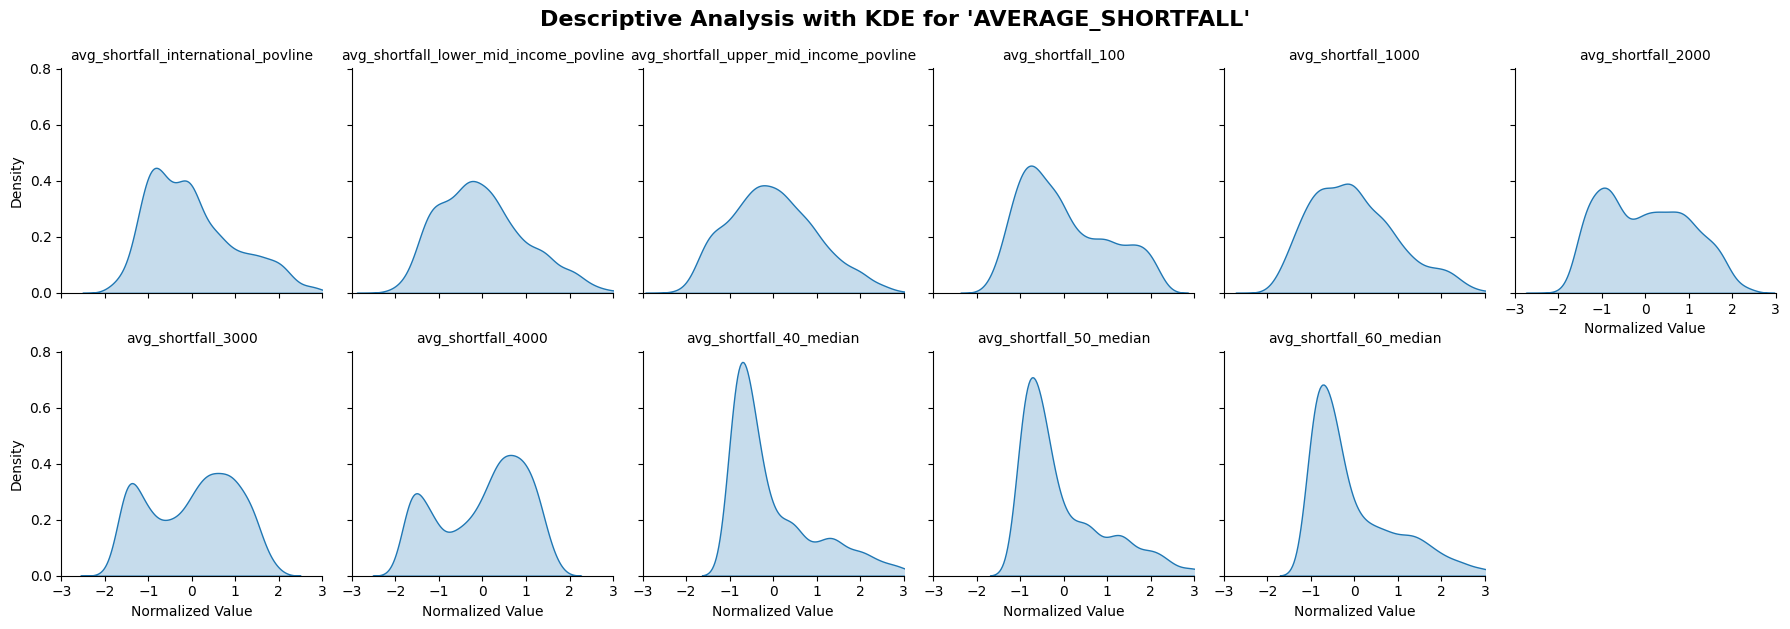

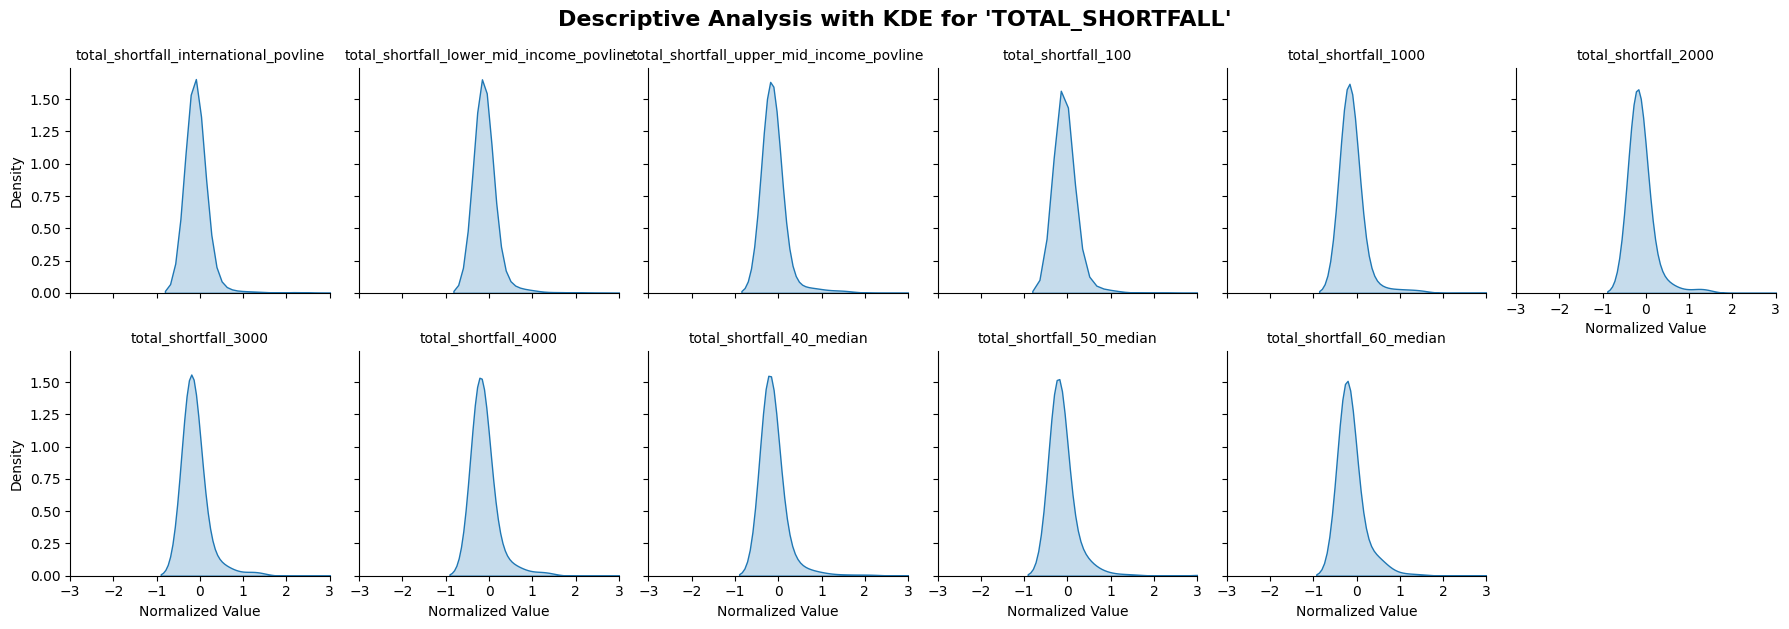

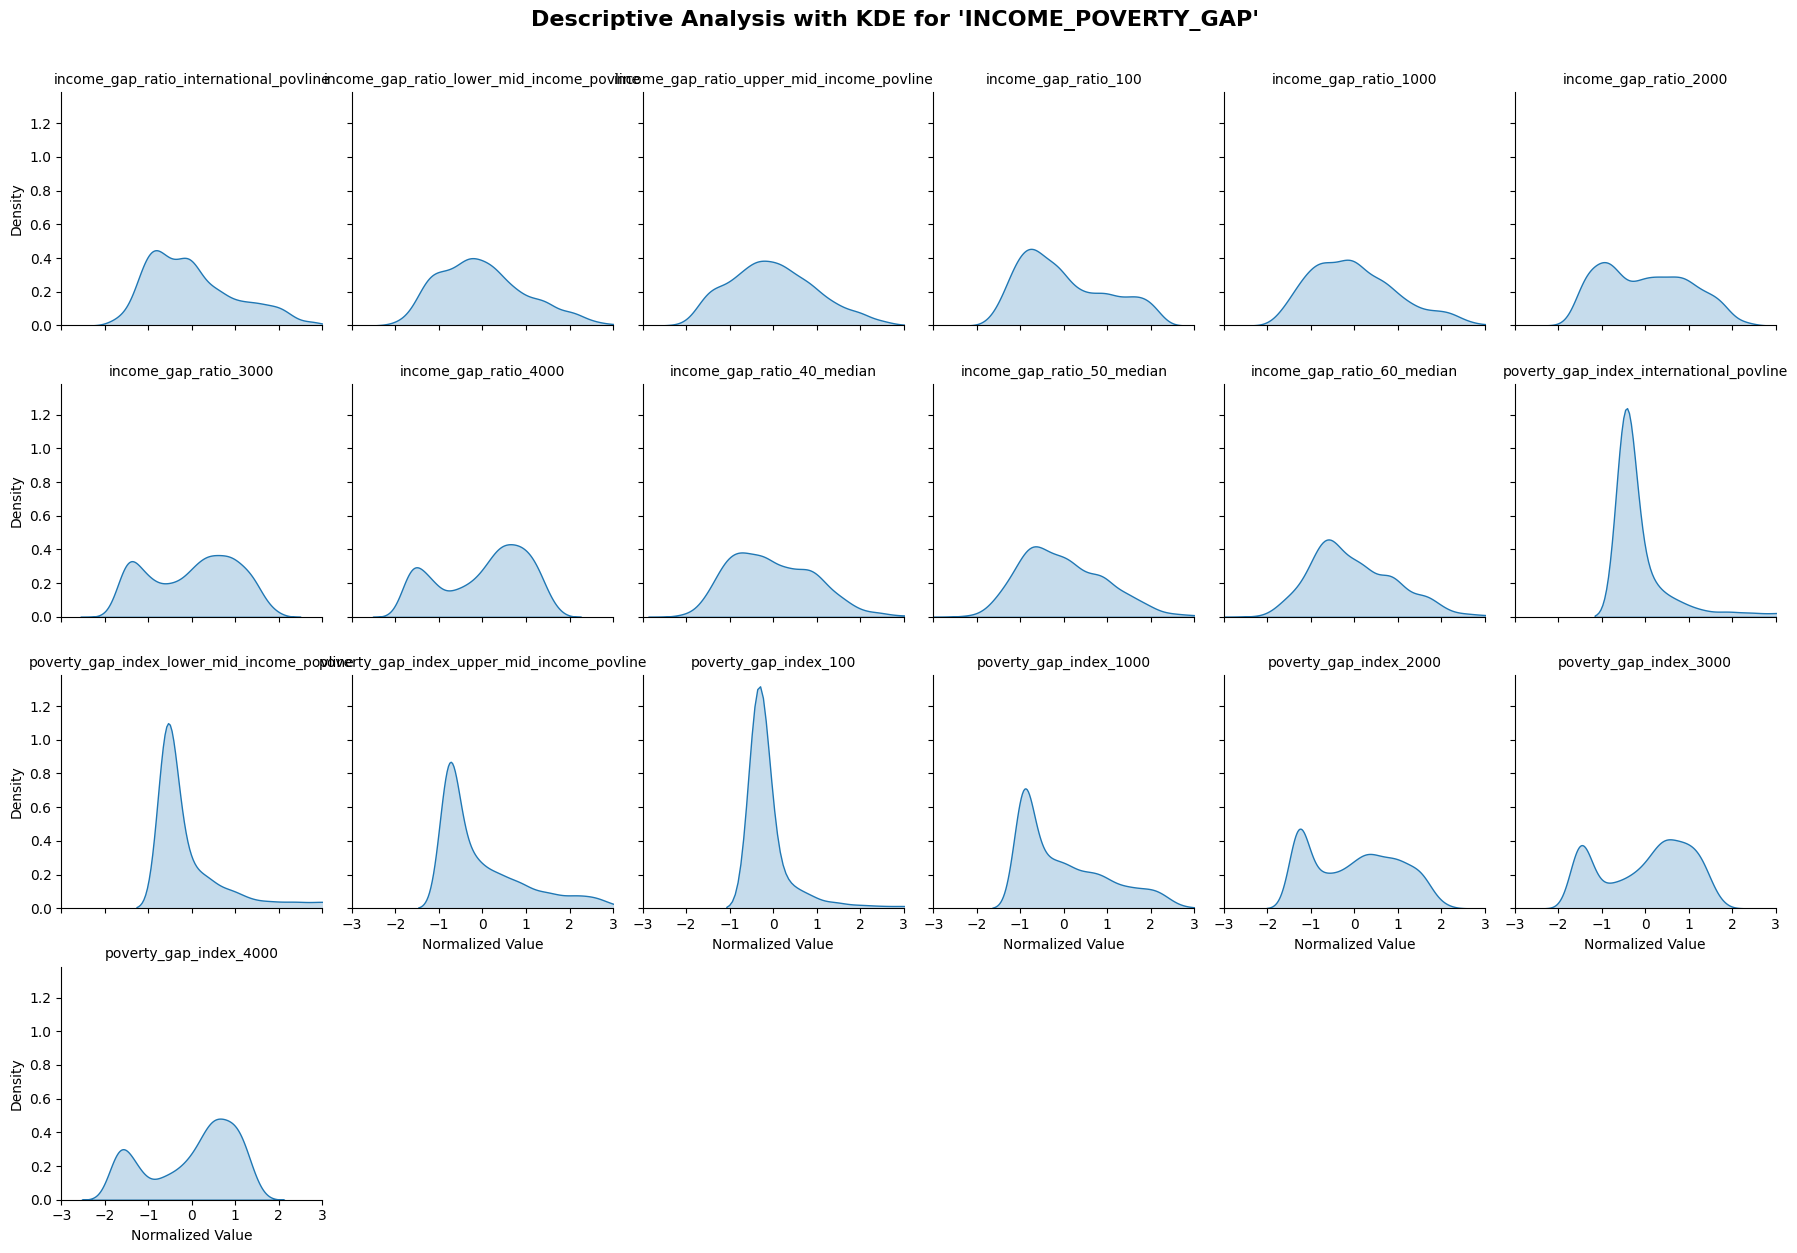

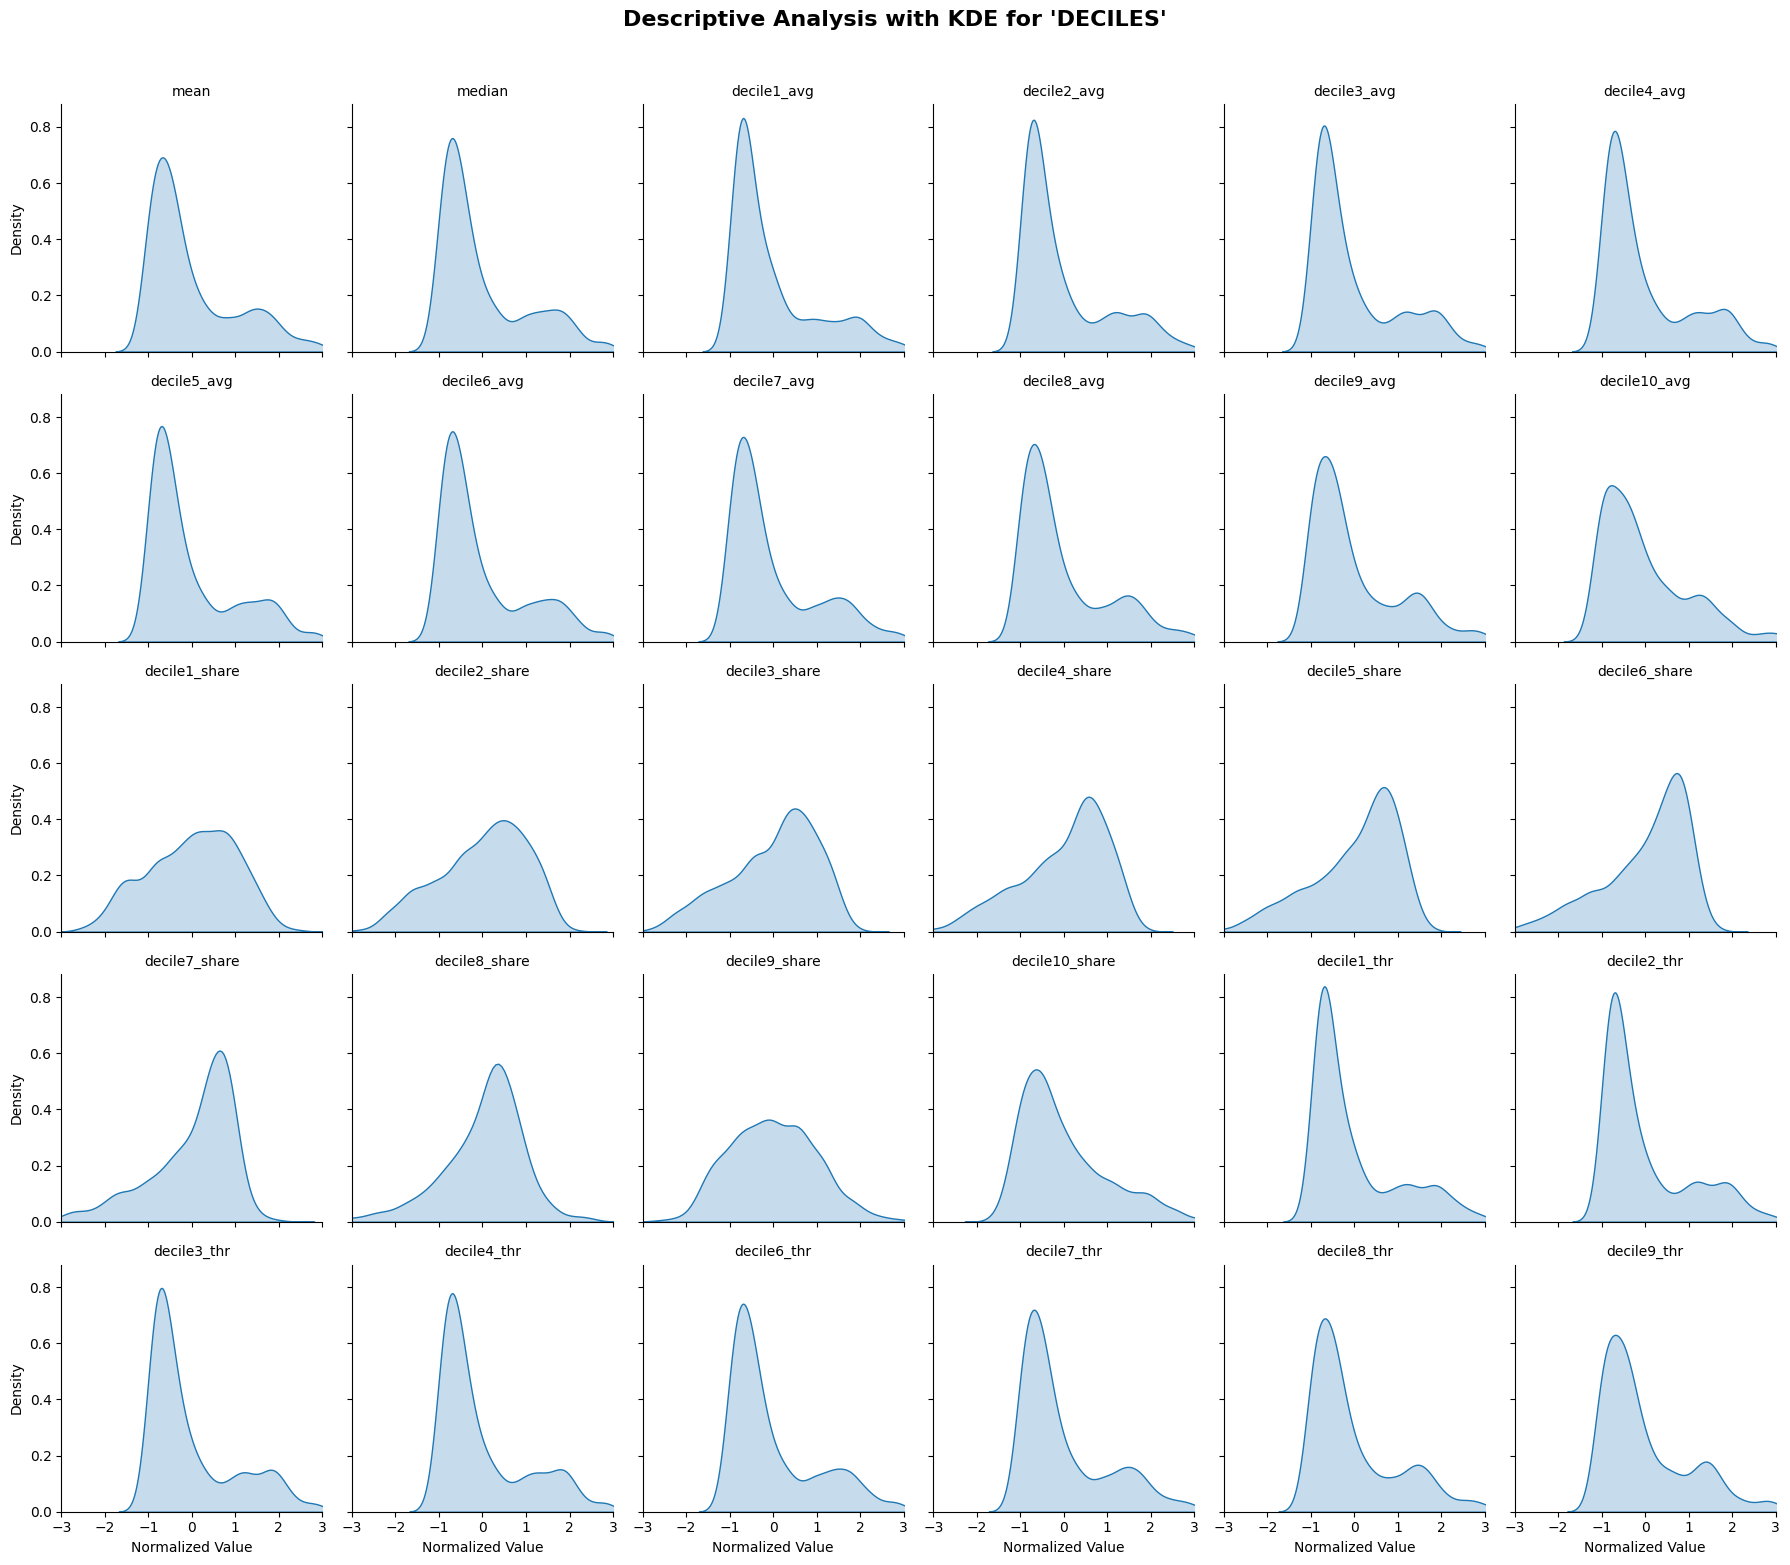

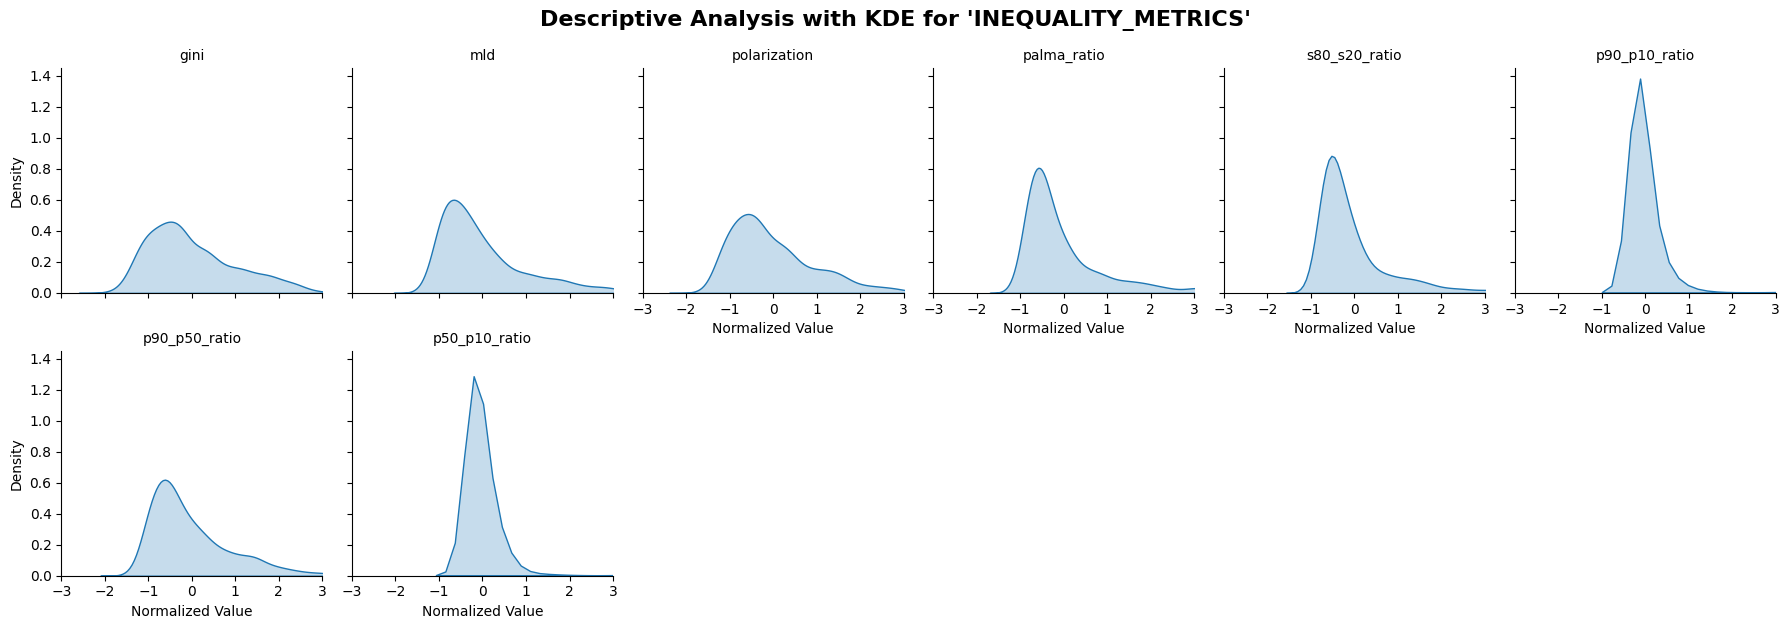

In [249]:
for name, dataset in datasets.items():
    # Normalize the dataset and transform it to long format
    data_scaled = pd.DataFrame(StandardScaler().fit_transform(dataset), columns=dataset.columns)
    data_melted = data_scaled.melt(var_name='variable', value_name='value')

    # Create the KDE plots grid
    g = sns.FacetGrid(data_melted, col="variable", col_wrap=6, height=3, aspect=1)
    g.map(sns.kdeplot, "value", fill=True)

    g.set(xlim=(-3, 3))  # Adjust X for a narrower range if the data is normalized
    g.set_titles("{col_name}")
    g.set_axis_labels("Normalized Value", "Density")
    g.tight_layout()
    g.fig.suptitle(f"Descriptive Analysis with KDE for '{name.upper()}'", y=1.04, fontsize=16, weight='bold')

    plt.show()

#### Transformación Box-Cox / Logarítmica de variables asimétricas (OPCIONAL)

In [250]:
variables_boxcox = [
    'headcount_ratio_international_povline', 'headcount_ratio_lower_mid_income_povline',
    'headcount_ratio_100', 'headcount_ratio_3000', 'headcount_ratio_4000',
    'headcount_international_povline', 'headcount_lower_mid_income_povline',
    'headcount_upper_mid_income_povline', 'headcount_100', 'headcount_1000',
    'headcount_2000', 'headcount_3000', 'headcount_4000', 'headcount_40_median',
    'headcount_50_median', 'headcount_60_median',

    'avg_shortfall_international_povline','avg_shortfall_40_median', 'avg_shortfall_50_median',
    'avg_shortfall_60_median',

    'total_shortfall_international_povline','total_shortfall_lower_mid_income_povline', 'total_shortfall_upper_mid_income_povline',
    'total_shortfall_100', 'total_shortfall_1000', 'total_shortfall_2000',
    'total_shortfall_3000', 'total_shortfall_4000', 'total_shortfall_40_median',
    'total_shortfall_50_median', 'total_shortfall_60_median',

    'income_gap_ratio_international_povline', 'income_gap_ratio_lower_mid_income_povline',
    'income_gap_ratio_upper_mid_income_povline', 'income_gap_ratio_40_median',
    'income_gap_ratio_50_median', 'income_gap_ratio_60_median',
    'poverty_gap_index_international_povline', 'poverty_gap_index_lower_mid_income_povline',
    'poverty_gap_index_upper_mid_income_povline', 'poverty_gap_index_100',

    'mean', 'median', 'decile1_avg', 'decile2_avg', 'decile3_avg', 'decile4_avg',
    'decile5_avg', 'decile6_avg', 'decile7_avg', 'decile8_avg', 'decile9_avg', 'decile10_avg',
    'decile1_share', 'decile2_share', 'decile3_share', 'decile4_share', 'decile5_share',
    'decile6_share', 'decile7_share', 'decile8_share', 'decile9_share',
    'decile1_thr', 'decile2_thr', 'decile3_thr', 'decile4_thr', 'decile6_thr',
    'decile7_thr', 'decile8_thr', 'decile9_thr',
    
    'gini', 'mld', 'polarization','palma_ratio', 's80_s20_ratio'
]


La transformación Box-Cox solo puede aplicarse a valores positivos debido por su definición matemática, ya que su fórmula incluye un término logarítmico para ciertos valores de λ y los logaritmos no están definidos para valores negativos. Por lo tanto, utilizamos la transformación Yeo-Johnson (una adaptación de Box-Cox que admite datos negativos).

In [251]:

lambda_dict_yeo = {}

transformer = PowerTransformer(method='yeo-johnson', standardize=False)

for var in variables_boxcox:
    try:
        data[var] = transformer.fit_transform(data[[var]]).flatten() 
        lambda_dict_yeo[var] = transformer.lambdas_[0] 
        data.rename(columns={var: f'yeo_{var}'}, inplace=True)
    
    except Exception as e:
        print(f"Failed to transform variable {var} with Yeo-Johnson: {e}")

In [252]:
# # Diccionario para almacenar los parámetros lambda de cada transformación
# lambda_dict = {}

# # Iterar sobre la lista de variables para transformar
# for var in variables_boxcox:
#     try:
#         # if (data[var] <= 0).any():
#         #     data[var] += 1e-6  

#         # Aplicar la transformación Box-Cox
#         data[var], lmbda = boxcox(data[var])
#         lambda_dict[var] = lmbda  # Guardar el valor de lambda
#         data.rename(columns={var: f'bx_{var}'}, inplace=True)

#     except Exception as e:
#         print(f"Error al transformar la variable {var}: {e}")

In [253]:
feat_num = [feat for feat in data.columns if feat not in feat_cat]
datasets = {name: data.iloc[:, start:end] for name, (start, end) in column_ranges.items()}

In [254]:
# for name, dataset in datasets.items():
#     # Normalize the dataset and transform it to long format
#     data_scaled = pd.DataFrame(StandardScaler().fit_transform(dataset), columns=dataset.columns)
#     data_melted = data_scaled.melt(var_name='variable', value_name='value')

#     # Create the KDE plots grid
#     g = sns.FacetGrid(data_melted, col="variable", col_wrap=6, height=3, aspect=1)
#     g.map(sns.kdeplot, "value", fill=True)

#     g.set(xlim=(-3, 3))  # Adjust X for a narrower range if the data is normalized
#     g.set_titles("{col_name}")
#     g.set_axis_labels("Normalized Value", "Density")
#     g.tight_layout()
#     g.fig.suptitle(f"Descriptive Analysis with KDE for '{name.upper()}'", y=1.04, fontsize=16, weight='bold')

#     plt.show()

### 3. Análisis e imputación de datos perdidos <a class="anchor" id="seccion_3"></a>

Observar el porcentaje de datos perdidos por columna

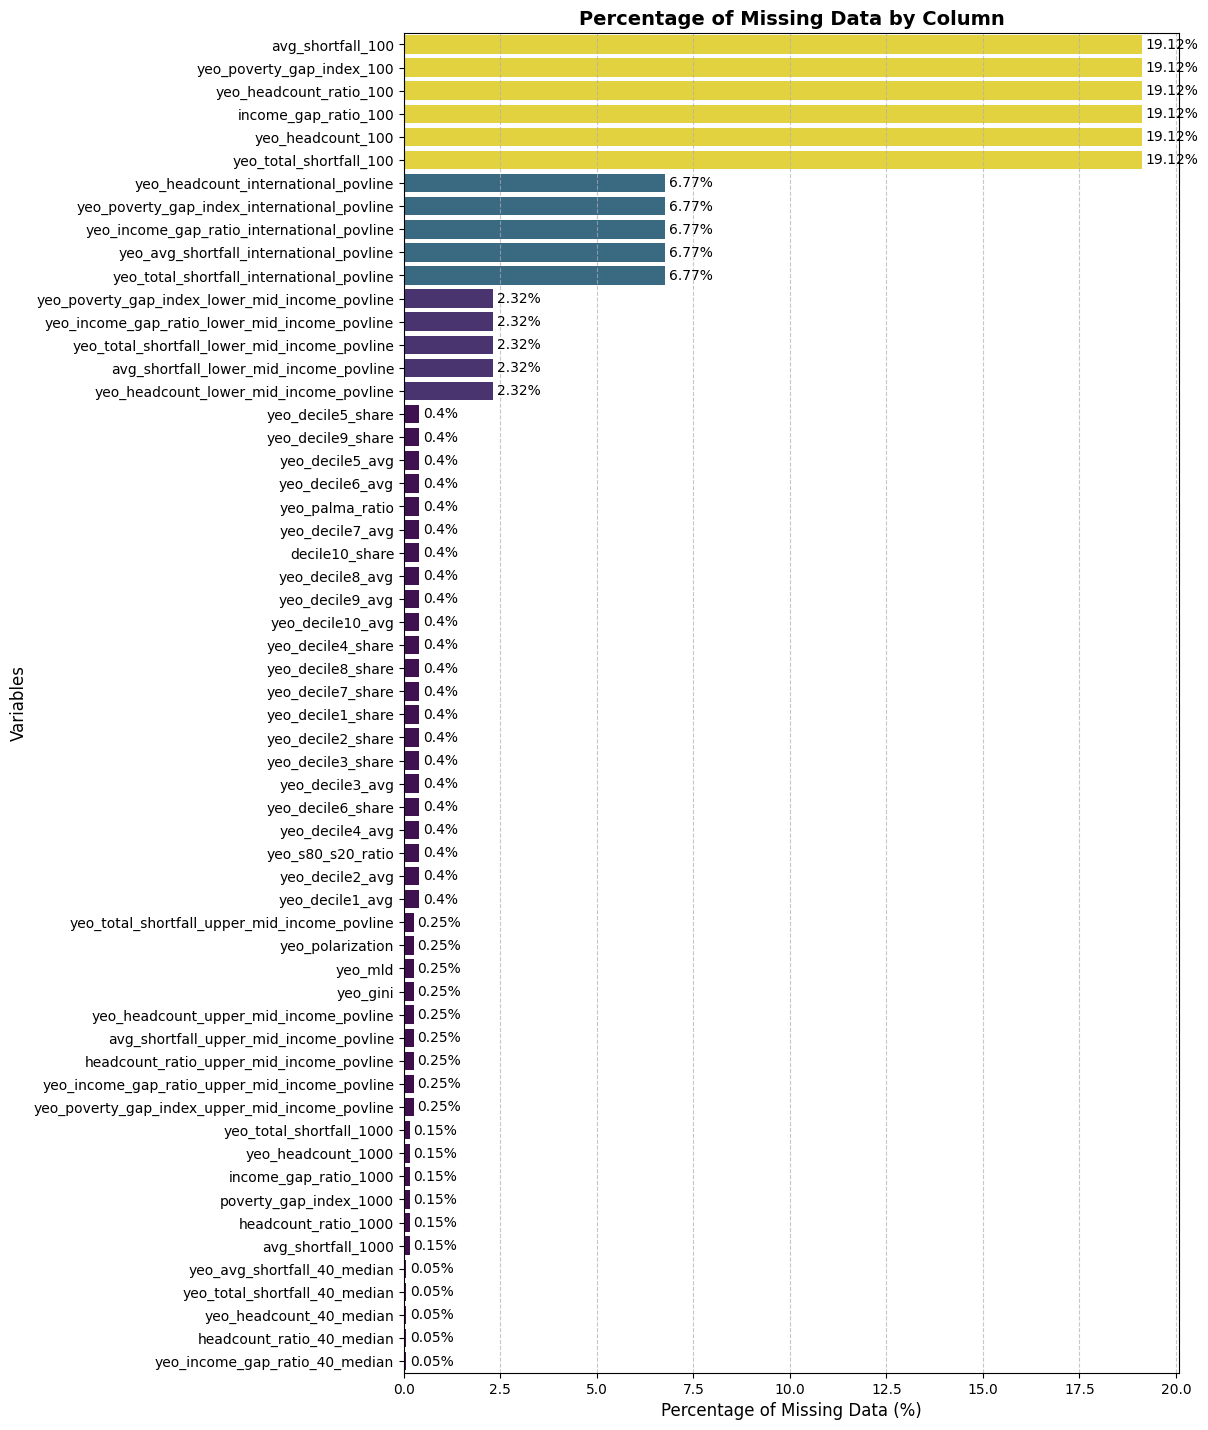

In [255]:
# Calculate percentage of missing data with 2 decimals
missing_percentages = data.isnull().mean() * 100
missing_percentages = missing_percentages[missing_percentages > 0].round(2)
missing_table = pd.DataFrame(missing_percentages, columns=["Percentage of Missing Data"])
missing_table = missing_table.sort_values(by="Percentage of Missing Data", ascending=False)

plt.figure(figsize=(10, max(6, len(missing_table) * 0.3)))
sns.barplot(x="Percentage of Missing Data", y=missing_table.index, data=missing_table, 
                 palette="viridis", hue=missing_table['Percentage of Missing Data'], legend=False)
plt.xlabel("Percentage of Missing Data (%)", fontsize=12)
plt.ylabel("Variables", fontsize=12)
plt.title("Percentage of Missing Data by Column", fontsize=14, weight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show percentages in each bar
for index, value in enumerate(missing_table["Percentage of Missing Data"]):
    plt.text(value + 0.1, index, f"{value}%", va='center', fontsize=10)

plt.show()

Eliminamos aquellas filas o países con una gran cantidad de datos perdidos, ya que corresponden a un número muy bajo de instancias del cual podemos prescindir.

In [256]:
data.dropna(subset=['decile10_share'], inplace=True)


Antes de imputar los datos perdidos restantes, solucionamos los outliers. Para facilitar el análisis, creamos diferentes subgrupos de características según su categoría.

In [257]:
datasets = {name: data.iloc[:, start:end] for name, (start, end) in column_ranges.items()}

Number of outliers replaced with NaN: 588
Percentage of cells replaced: 0.28%


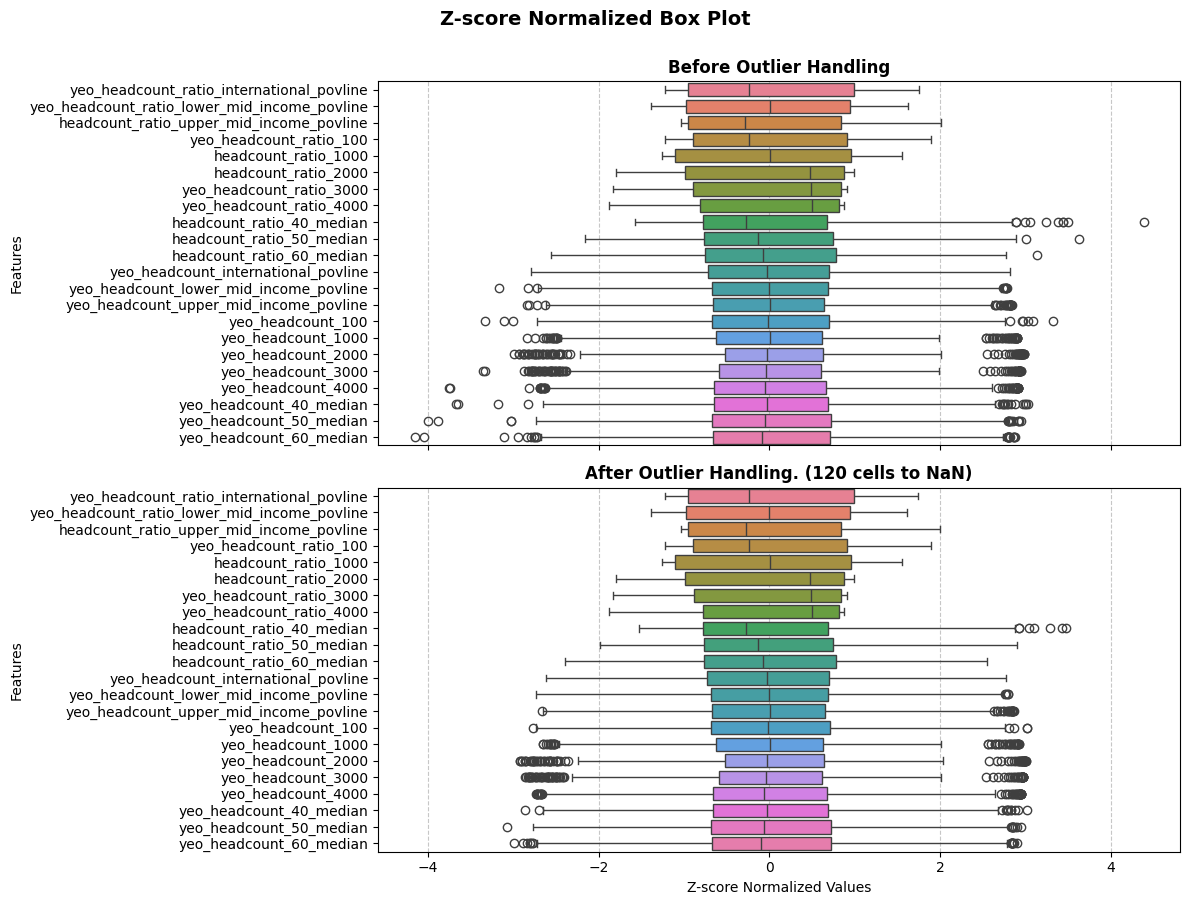

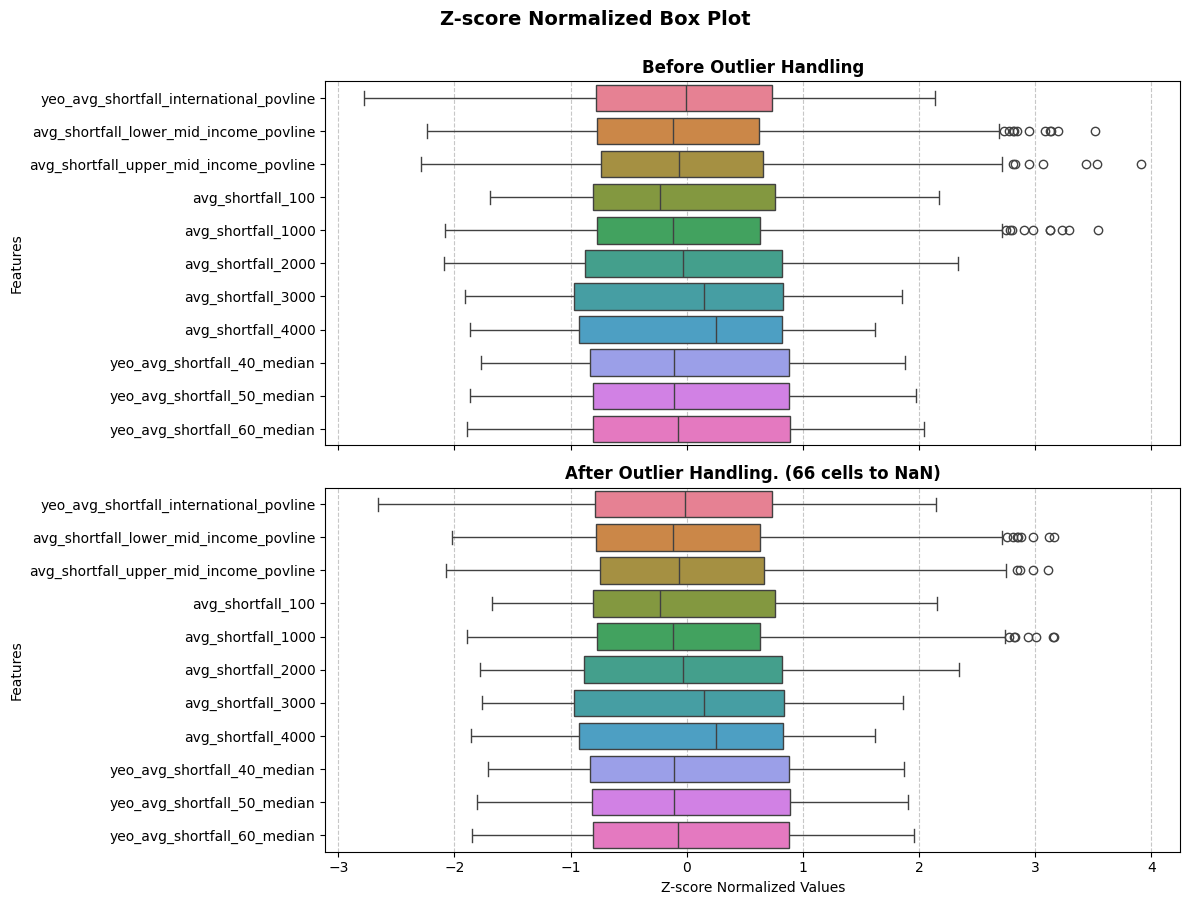

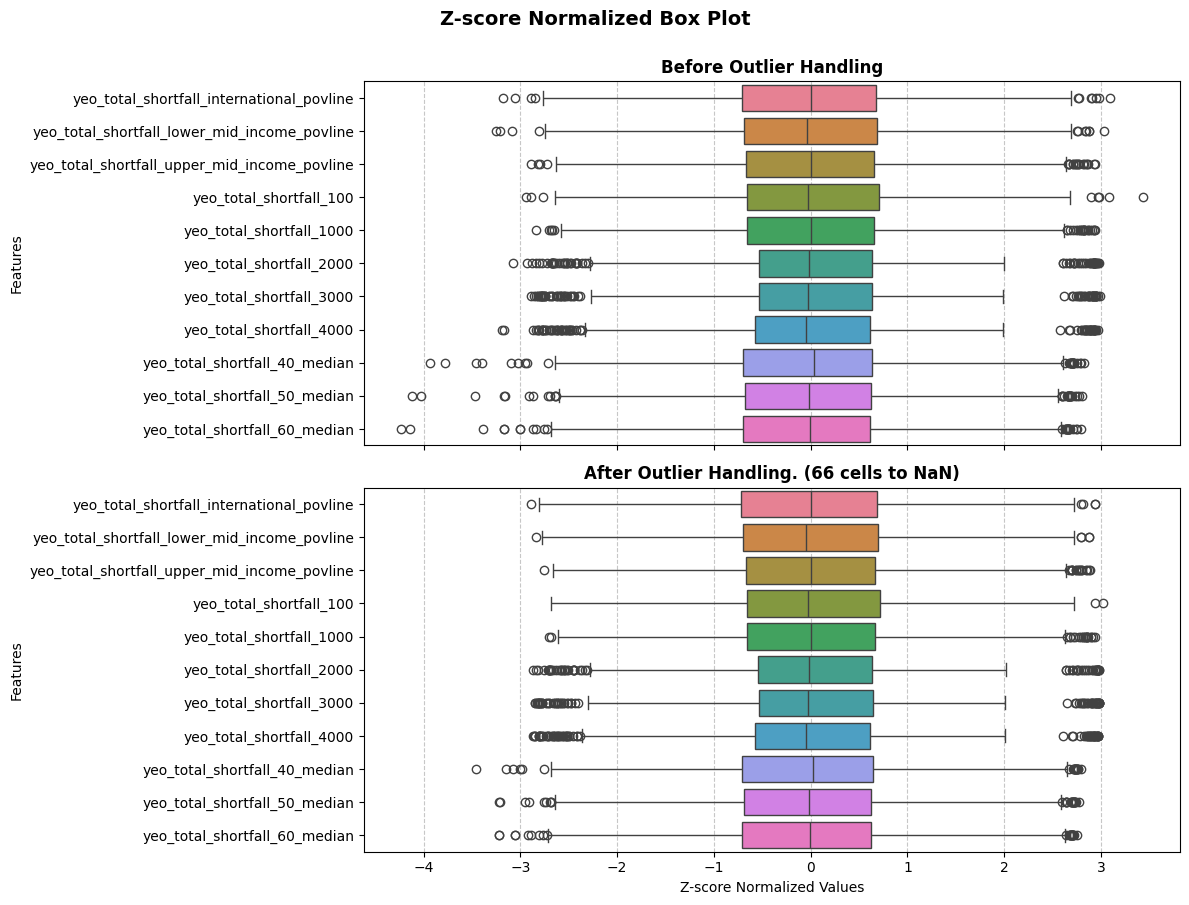

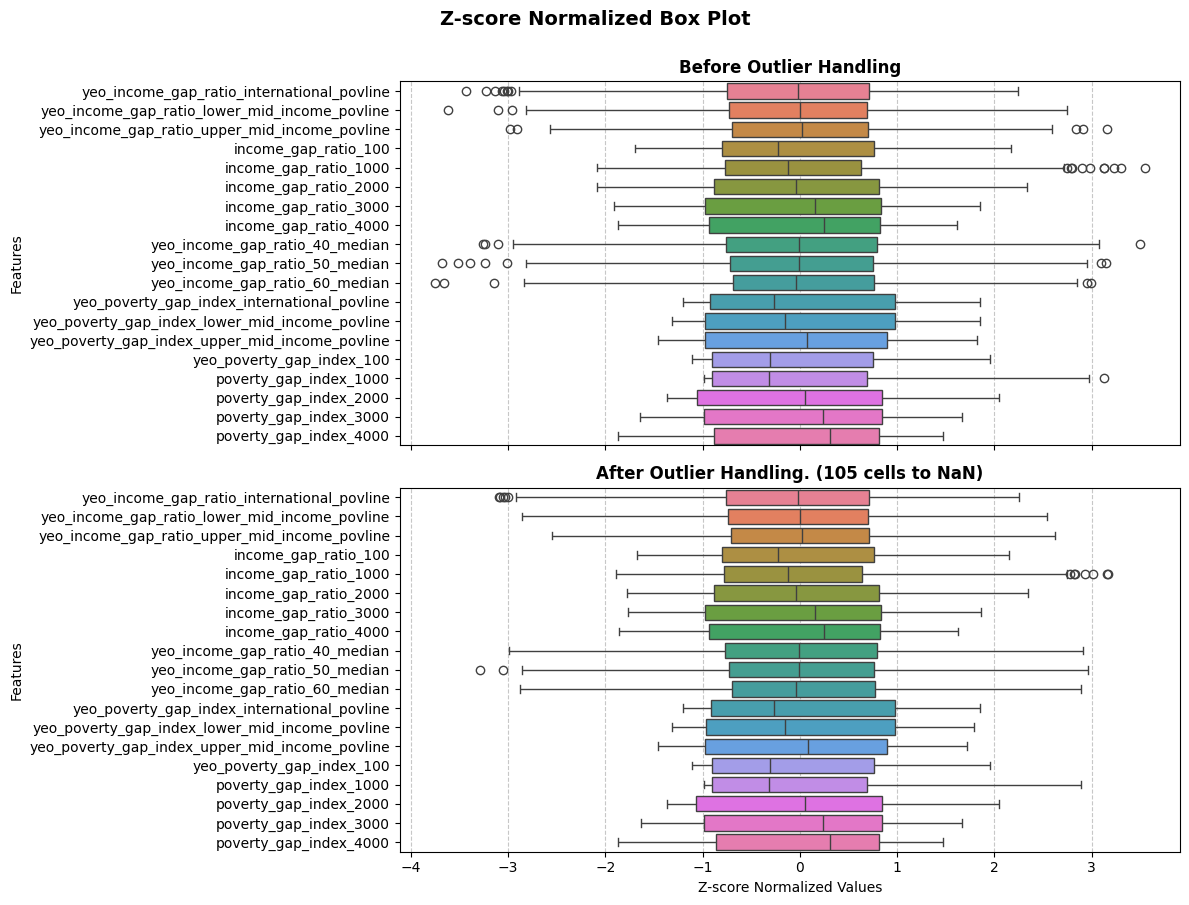

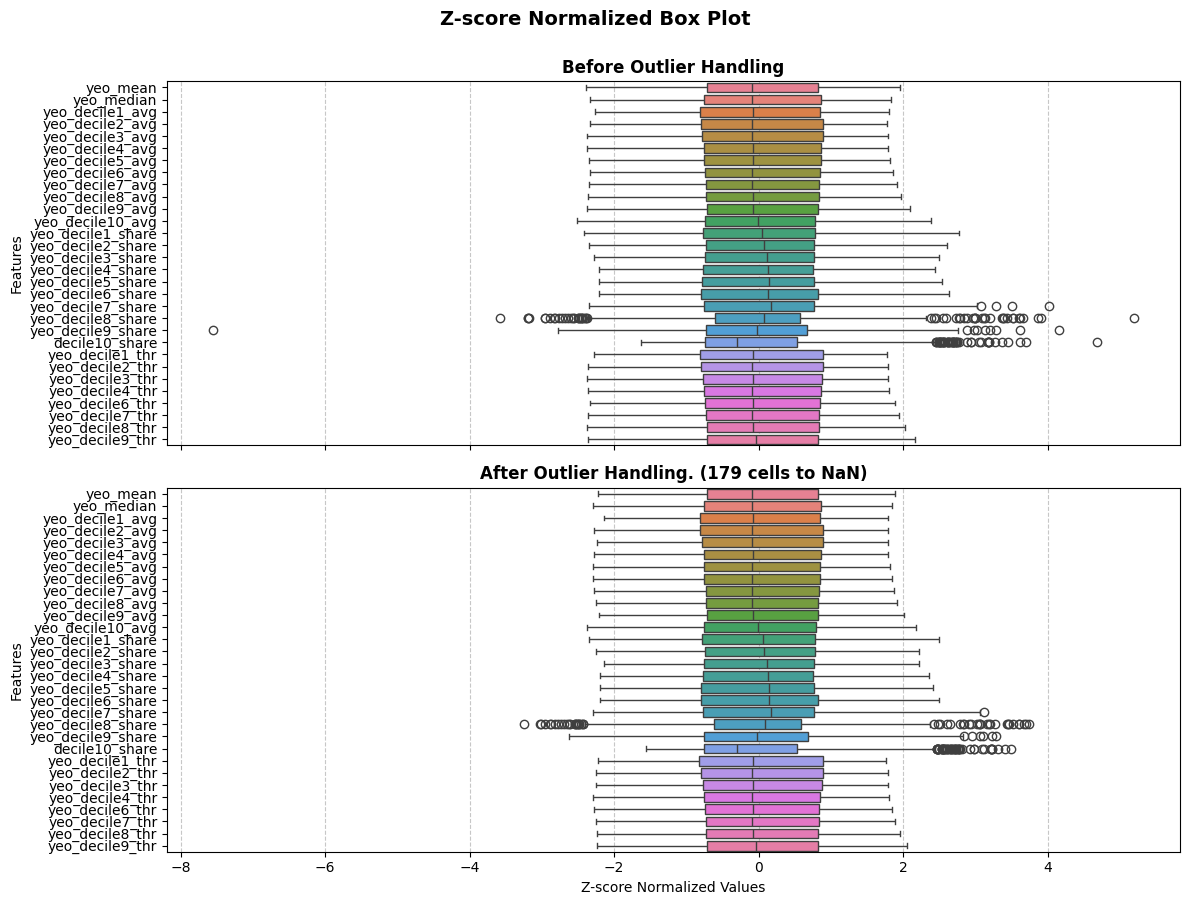

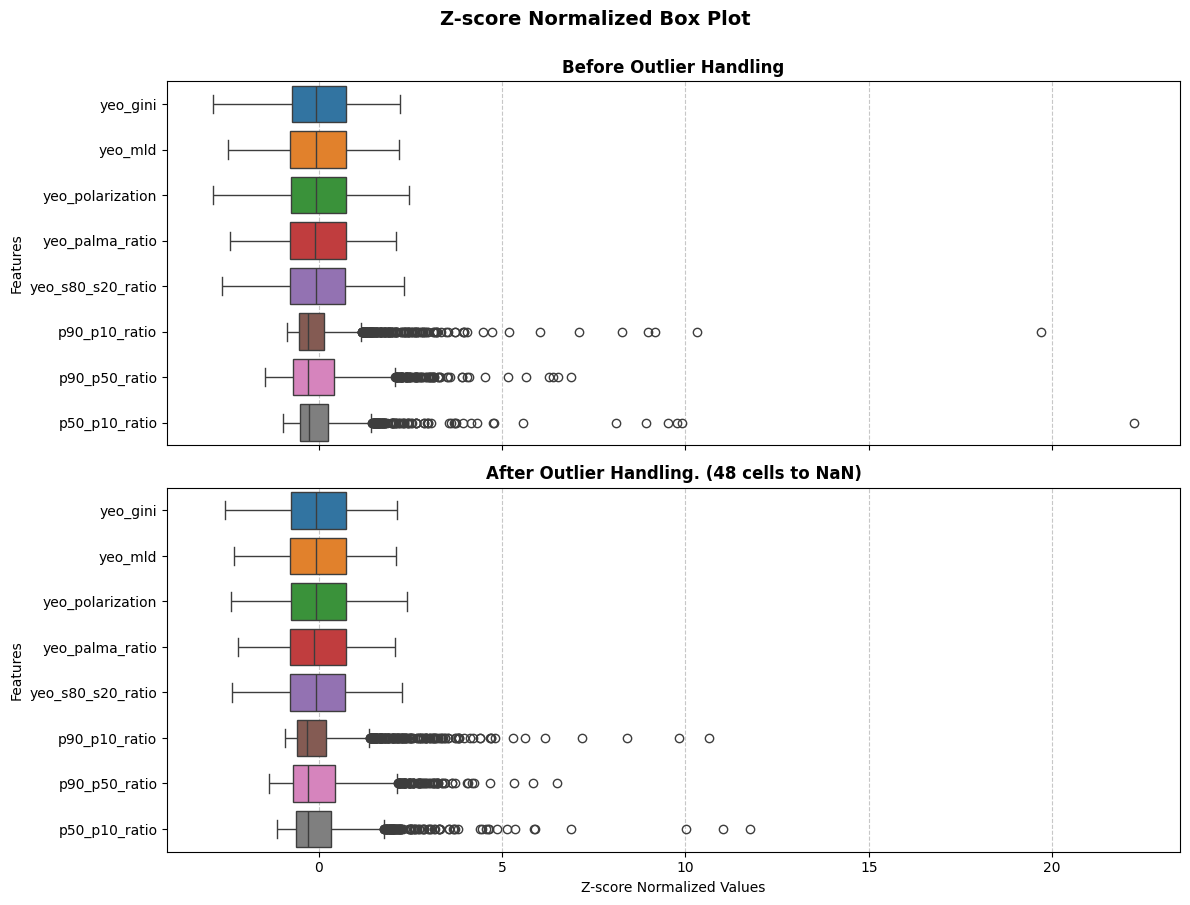

In [258]:
# Apply outlier handling to 'data'
data, data_outliers_replaced, perc_replaced = handleData.replace_outliers_with_nan(data, confidence_interval=0.9973)
print(f"Number of outliers replaced with NaN: {data_outliers_replaced}")
print(f"Percentage of cells replaced: {perc_replaced:.2f}%")


# Apply outlier handling to each dataset in the dictionary and visualize with Z-score normalization
for name, dataset in datasets.items():

    # Normalize without handling outliers
    normalized_dataset_no_outliers = dataset.apply(zscore, nan_policy='omit')
    
    # Replace outliers with NaN in each dataset and normalize again
    datasets[name], cells_replaced, _ = handleData.replace_outliers_with_nan(normalized_dataset_no_outliers, confidence_interval=0.9973)
    normalized_dataset_outliers_handled = datasets[name].apply(zscore, nan_policy='omit')
    
    # Create a figure with 2 subplots (one above the other) to compare before and after handling outliers
    fig, axes = plt.subplots(2, 1, figsize=(12, 9), sharex=True)
    
    # Plot Z-score normalized dataset before outlier handling
    sns.boxplot(data=normalized_dataset_no_outliers, orient="h", ax=axes[0])
    axes[0].set_title(f"Before Outlier Handling", fontdict={'weight': 'bold', 'size': 12})
    axes[0].set_xlabel("Z-score Normalized Values")
    axes[0].set_ylabel("Features")
    axes[0].grid(axis='x', linestyle='--', alpha=0.7)
    
    # Plot Z-score normalized dataset after outlier handling
    sns.boxplot(data=normalized_dataset_outliers_handled, orient="h", ax=axes[1])
    axes[1].set_title(f"After Outlier Handling. ({cells_replaced} cells to NaN)", fontdict={'weight': 'bold', 'size': 12})
    axes[1].set_xlabel("Z-score Normalized Values")
    axes[1].set_ylabel("Features")
    axes[1].grid(axis='x', linestyle='--', alpha=0.7)

    
    # Adjust the layout and add suptitle
    plt.suptitle(f"Z-score Normalized Box Plot", y=1, fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Show the plot
    plt.show()

Imputar con MICE regresión lineal los missing restantes

In [259]:
# Solve numerical missing data
imputer = IterativeImputer(estimator=LinearRegression(), random_state=1, max_iter=10)

# Ignore convergence warning while imputing
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    data[feat_num] = imputer.fit_transform(data[feat_num])

data = data.reset_index(drop=True)

Detectar y eliminar los outliers multivariantes mediante un test Hotelling T2 (como t de Student pero multivariante). El test mide la distancia de una observación en un el conjunto de datos multivariante respecto de la media global, considerando la estructura de correalación y varianza. Ajusta las distancias considerando las covarianzas.

Number of multivariate outliers detected: 244
The cleaned dataset now has 1772 rows.


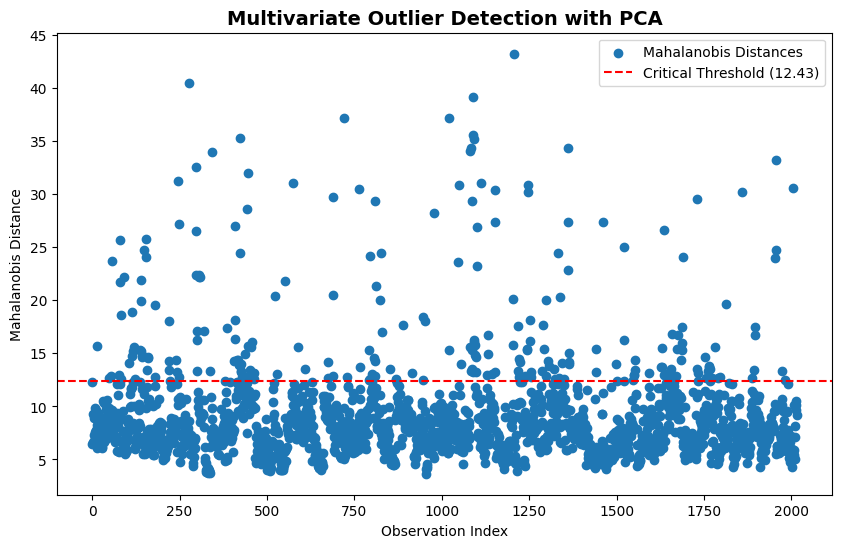

In [260]:
# Select the numeric columns and apply PCA (ensure covariance matrix invertible)
numeric_data = data.iloc[:, 5:107]
pca = PCA()
pca_data = pca.fit_transform(numeric_data)  

# Compute the mean and covariance matrix in the PCA space
mean_vector = np.mean(pca_data, axis=0)
cov_matrix = np.cov(pca_data, rowvar=False)

# Calculate Hotelling's T² statistic in the PCA space
inv_cov_matrix = np.linalg.inv(cov_matrix) # inverse of the covariance matrix 
centered_data = pca_data - mean_vector
T2_statistics = np.einsum('ij,jk,ik->i', centered_data, inv_cov_matrix, centered_data)  # Efficient T² calculation

# Determine the critical threshold
n, p = numeric_data.shape
threshold = f.ppf(0.9973, dfn=p, dfd=n-p) * p * (n-1) / (n-p) 

outliers = np.where(T2_statistics > threshold)[0]
num_outliers = len(outliers)
print(f"Number of multivariate outliers detected: {num_outliers}")

data.drop(index=outliers, inplace=True)
data.reset_index(drop=True, inplace= True)
print(f"The cleaned dataset now has {data.shape[0]} rows.")

# Mahalanobis distance plot to visualize multivariate anomalies
mahalanobis_distances = np.sqrt(T2_statistics)
critical_value = np.sqrt(threshold)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(mahalanobis_distances)), mahalanobis_distances, label="Mahalanobis Distances")
plt.axhline(y=critical_value, color='r', linestyle='--', label=f"Critical Threshold ({critical_value:.2f})")
plt.xlabel("Observation Index")
plt.ylabel("Mahalanobis Distance")
plt.title("Multivariate Outlier Detection with PCA", fontsize=14, weight='bold')
plt.legend()
plt.show()


In [261]:
datasets = {name: data.iloc[:, start:end] for name, (start, end) in column_ranges.items()}

### 4. Análisis de correlaciones y reducción de la dimensionalidad <a class="anchor" id="seccion_4"></a>


Realizar un análisis de correlaciones y obtener un gráfico de pareto tras PCA por subgrupos.

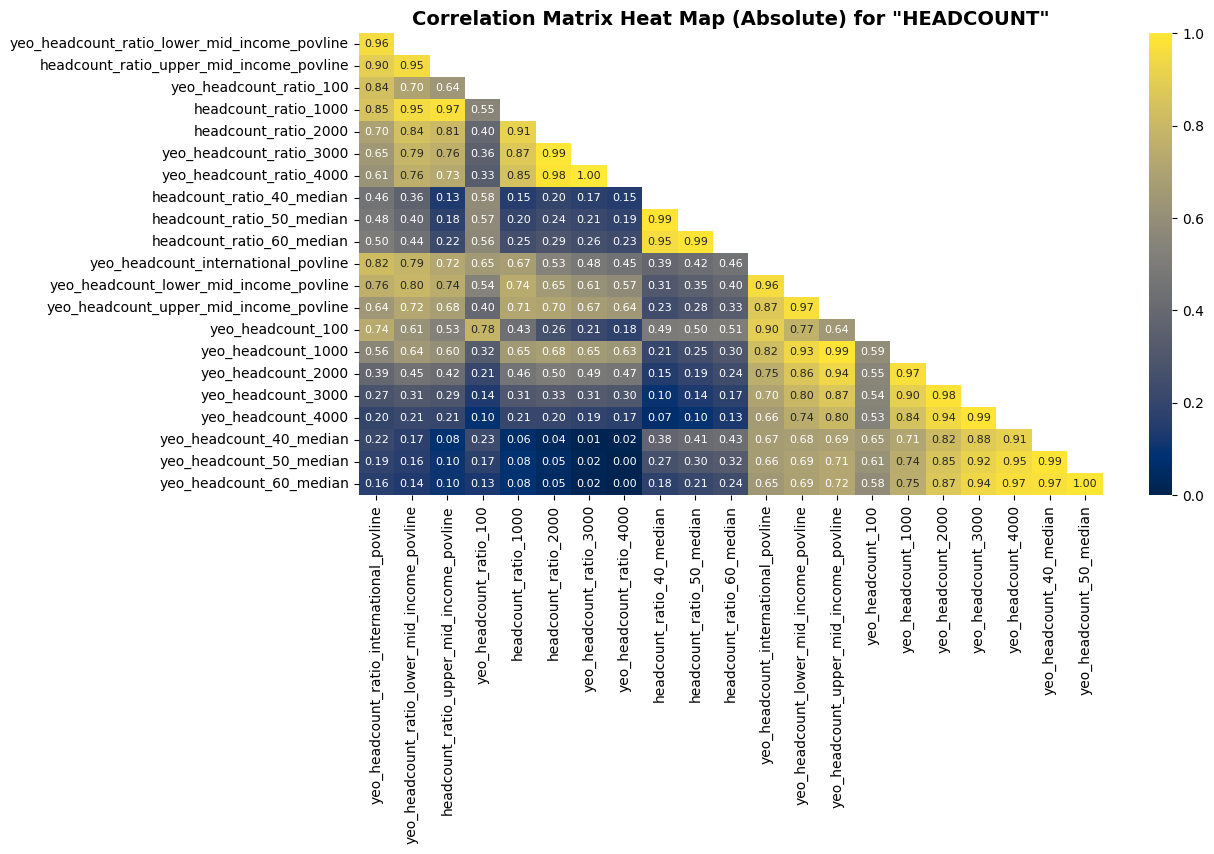

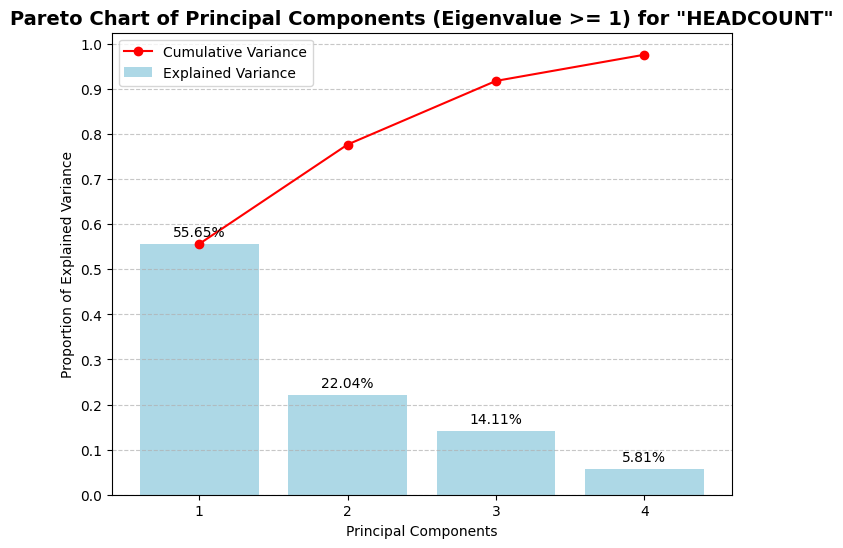

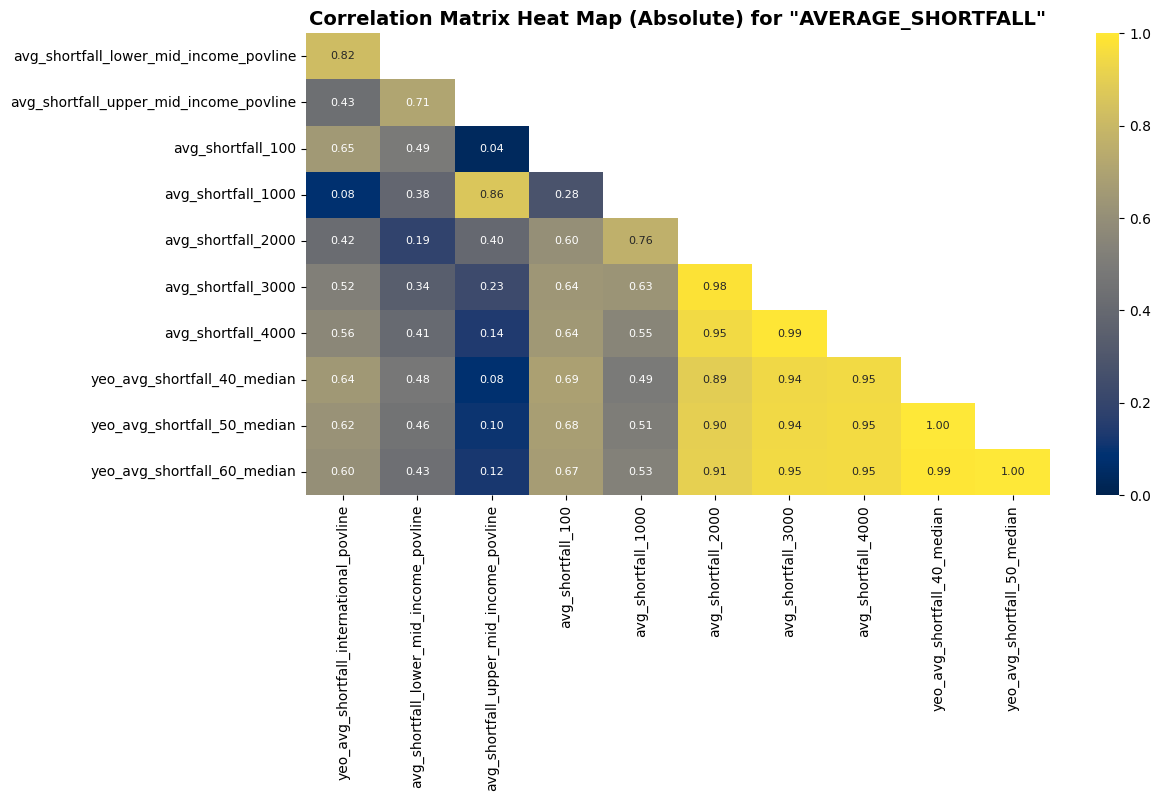

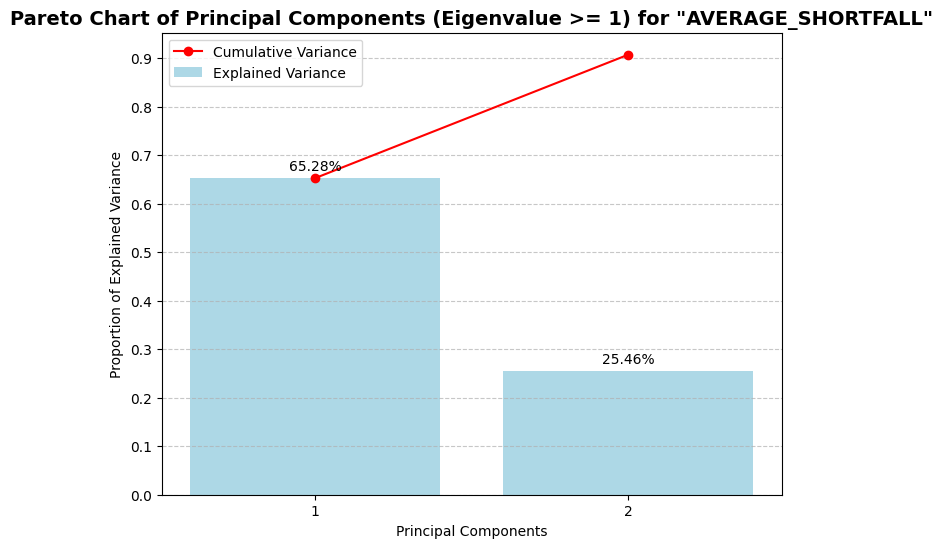

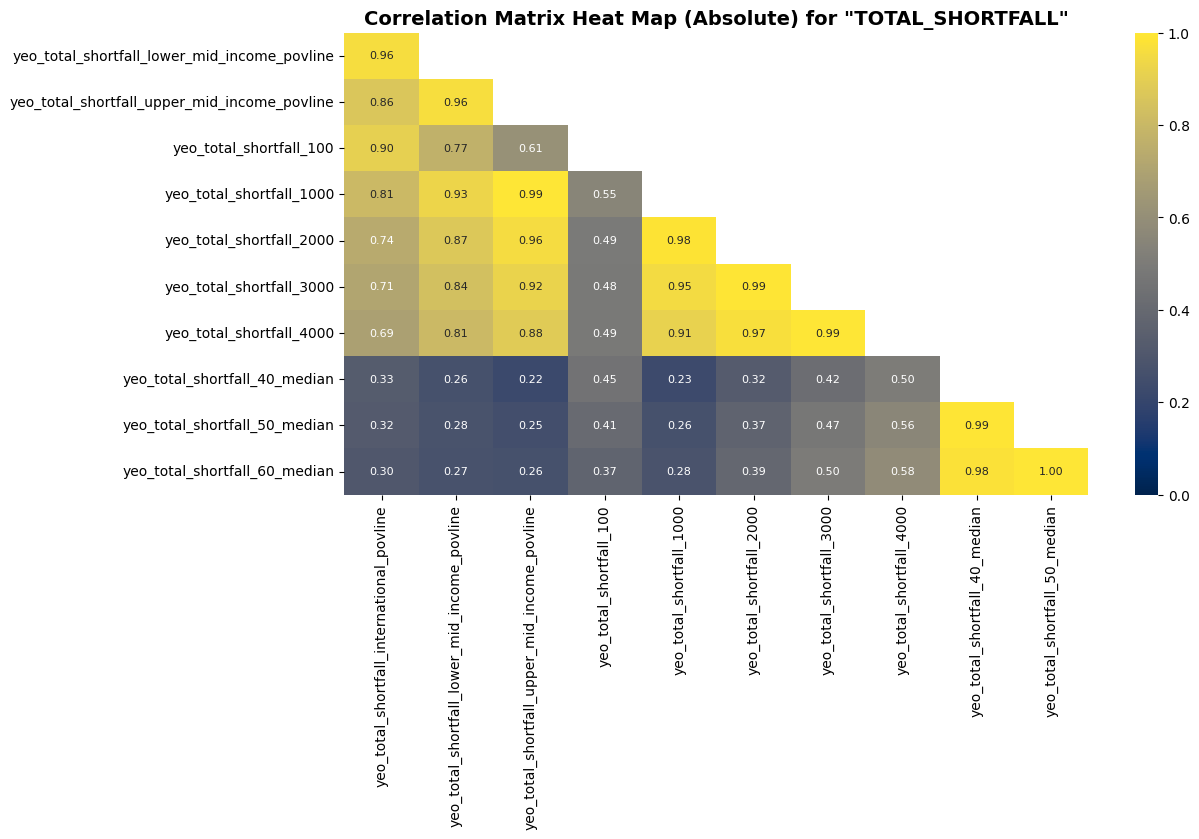

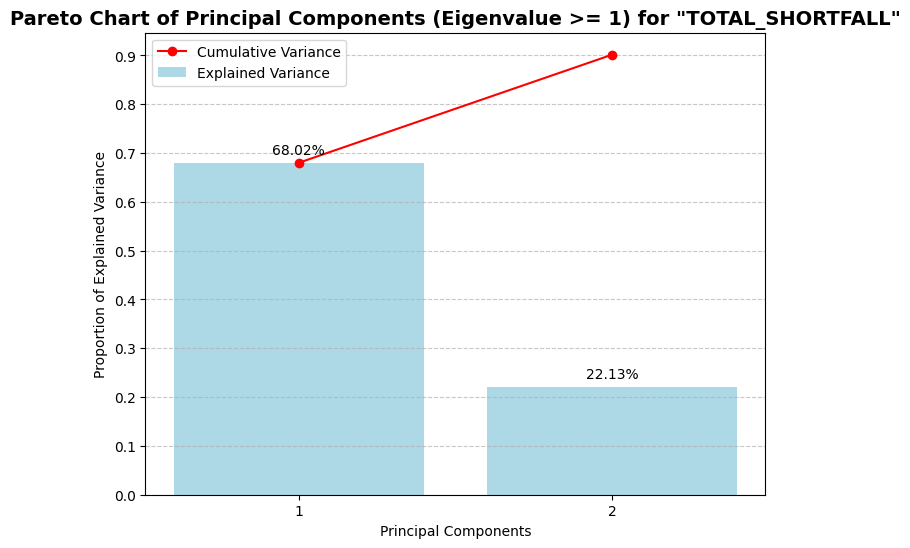

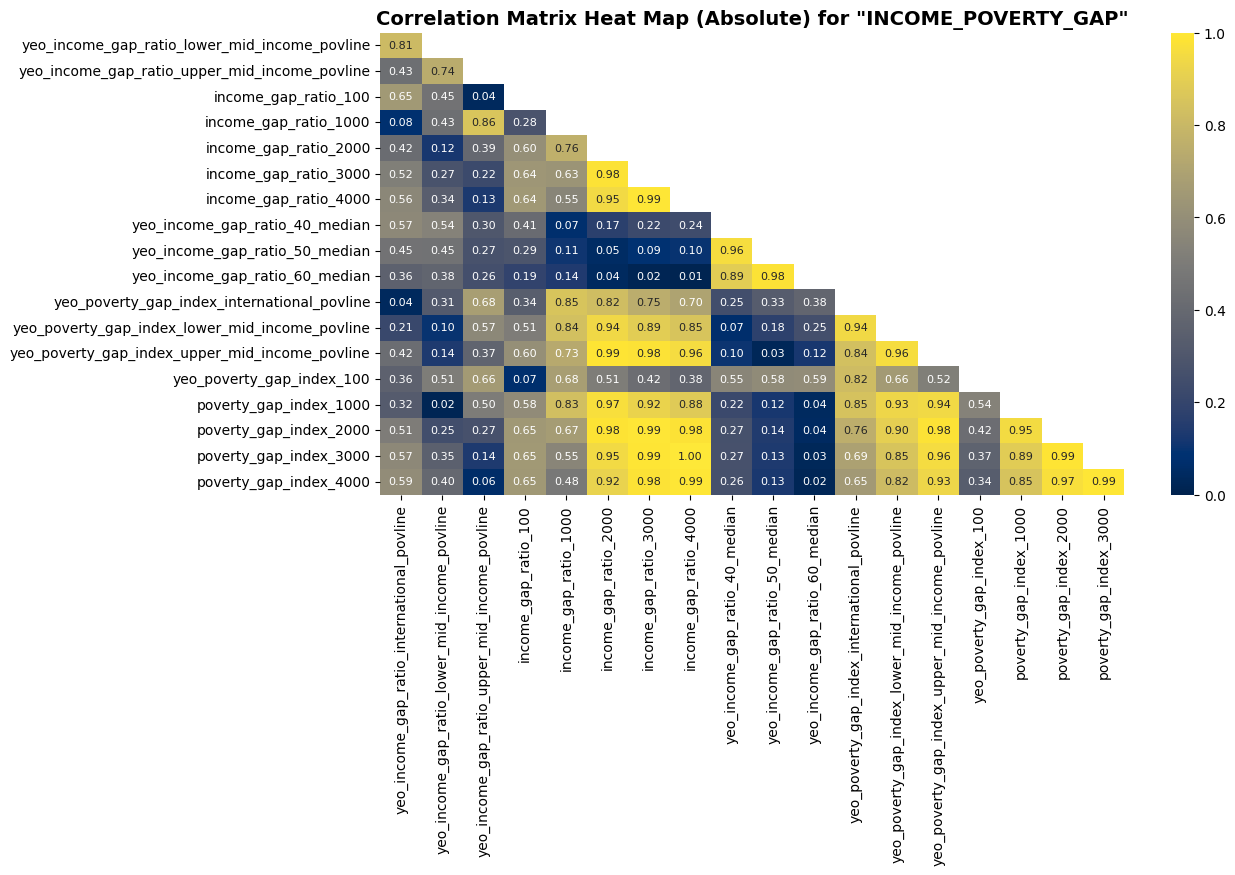

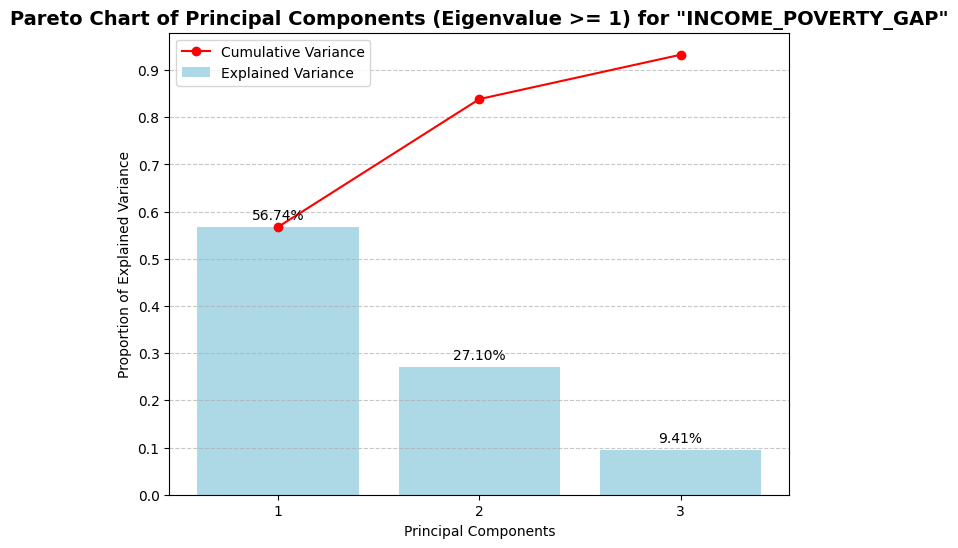

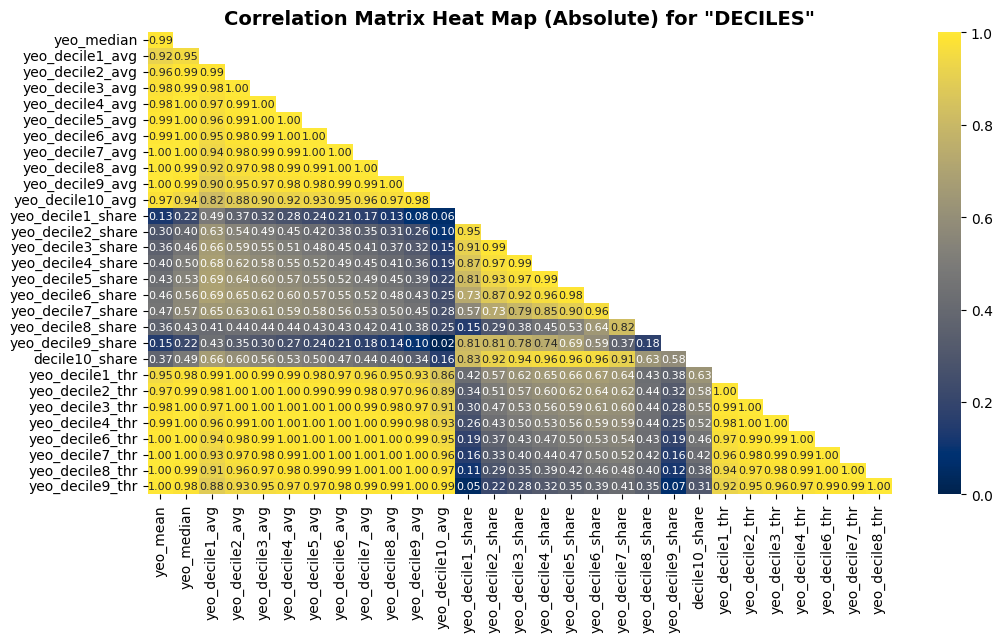

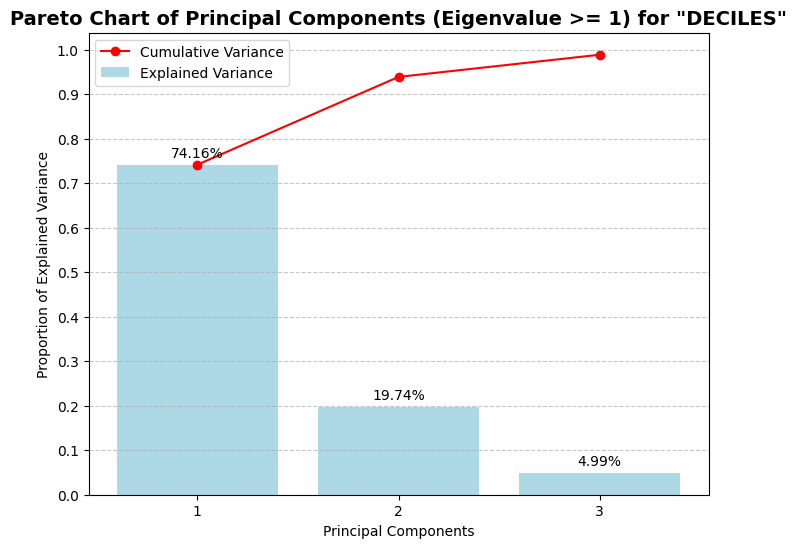

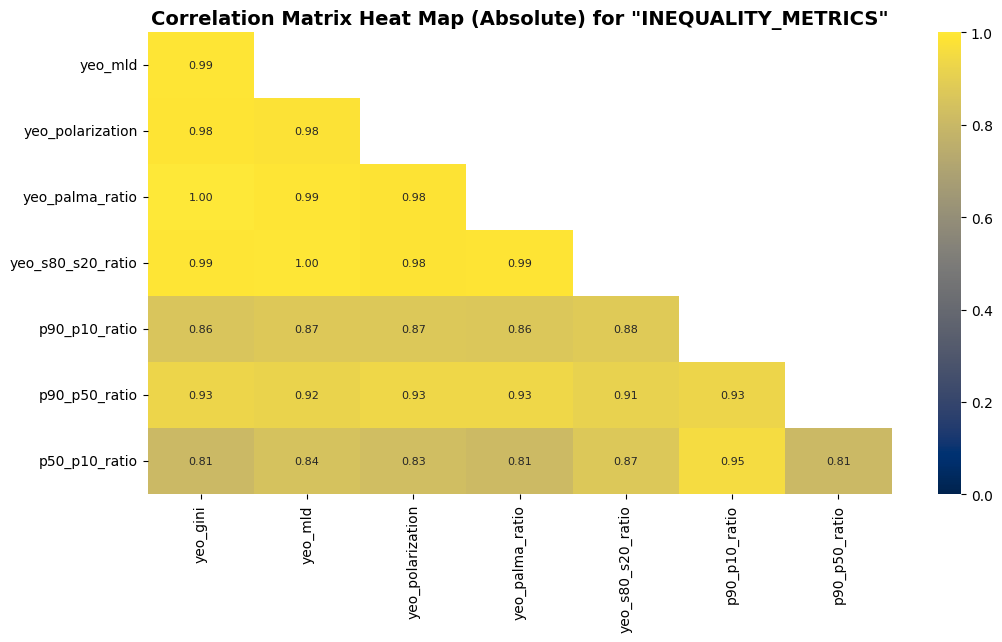

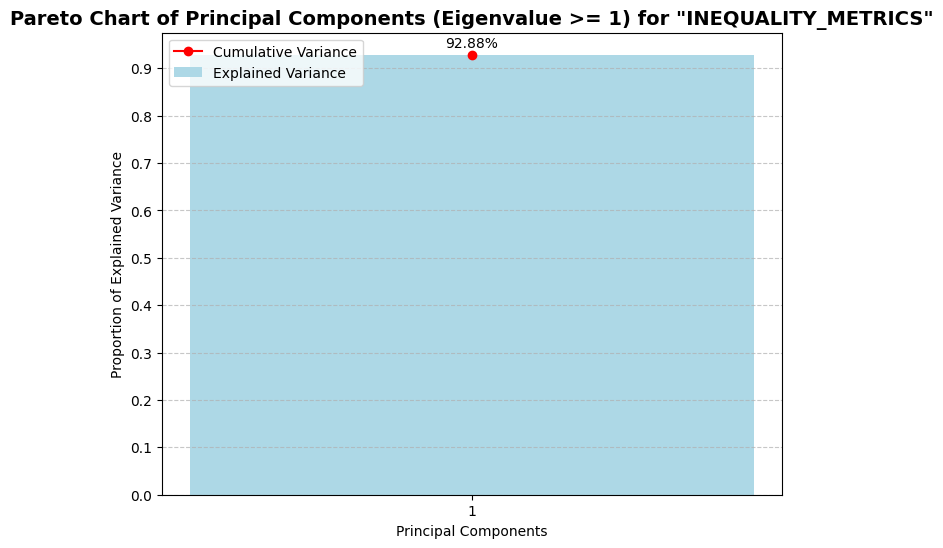

In [278]:
dataset_PCA = data.iloc[:, :7]

for name, dataset in datasets.items():

    ## CORRELATION MATRIX HEAT MAP (VALORES ABSOLUTOS)
    corr_num = dataset.corr().abs()  # Toma el valor absoluto de la matriz de correlación
    mask = np.triu(np.ones_like(corr_num, dtype=bool))  # Máscara para ocultar la parte superior derecha duplicada

    plt.figure(figsize=(12, 6))
    sns.heatmap(corr_num.iloc[1:, :-1], mask=mask[1:, :-1], annot=True, fmt=".2f",
                cmap="cividis", annot_kws={"size": 8}, vmin=0, vmax=1)  # Valores de 0 a 1
    plt.title(f'Correlation Matrix Heat Map (Absolute) for "{name.upper()}"', fontdict={'fontsize': 14, 'weight': 'bold'})
    plt.show()

    ## PCA & PARETO CHART
    # Standardize using Z-score
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(dataset)

    pca = PCA()
    pca_data = pca.fit_transform(data_standardized)
    explained_variance = pca.explained_variance_ratio_
    eigenvalues = pca.explained_variance_  # Extract eigenvalues

    # Select components with eigenvalue >= 1
    n_components = np.sum(eigenvalues >= 1)
    explained_variance_N = explained_variance[:n_components]
    cumulative_variance_N = np.cumsum(explained_variance_N)

    # Pareto Chart
    plt.figure(figsize=(8, 6))
    components = np.arange(1, n_components + 1)

    # Explained and cumulative variance
    plt.bar(components, explained_variance_N, color='lightblue', label="Explained Variance")
    plt.plot(components, cumulative_variance_N, marker='o', color='r', label="Cumulative Variance")

    plt.xlabel("Principal Components")
    plt.ylabel("Proportion of Explained Variance")
    plt.title(f'Pareto Chart of Principal Components (Eigenvalue >= 1) for "{name.upper()}"', fontdict={'fontsize': 14, 'weight': 'bold'})

    # Add labels with the percentage variability
    for i in range(len(components)):
        plt.text(components[i], explained_variance_N[i] + 0.01, f"{explained_variance_N[i]:.2%}", ha='center', va='bottom', fontsize=10)

    plt.xticks(components)
    plt.legend(loc='upper left', title_fontsize='medium', prop={'size': 10})
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().yaxis.set_major_locator(MultipleLocator(0.1))  # Set grid lines every 0.1 on the y-axis
    plt.show()

    # Select and store components based on eigenvalue >= 1
    pca_columns = [f"{name}_PCA{i+1}" for i in range(n_components)]
    dataset_PCA_subset = pd.DataFrame(pca_data[:, :n_components], columns=pca_columns)
    dataset_PCA = pd.concat([dataset_PCA, dataset_PCA_subset], axis=1)


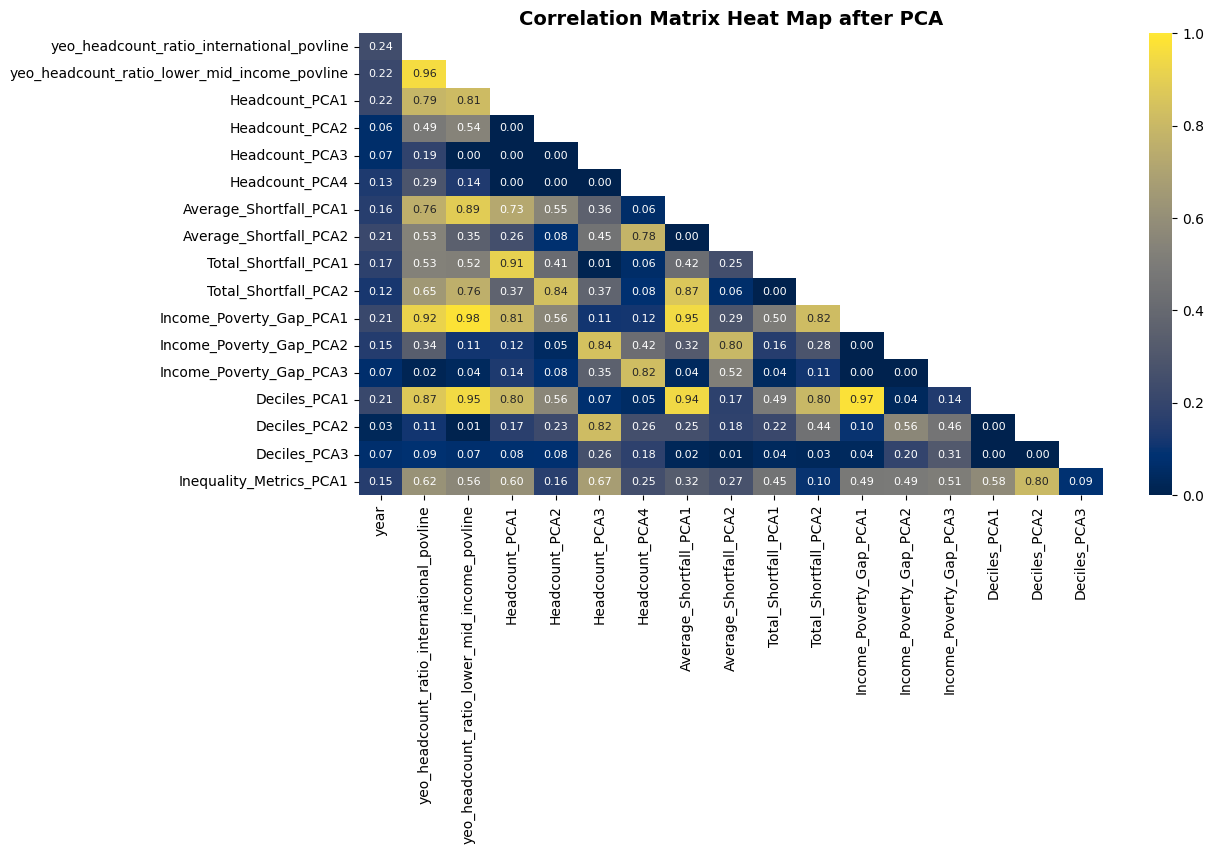

In [279]:
dataset_PCA
feat_names = dataset_PCA.columns
feat_num = [feat for feat in feat_names if feat not in feat_cat]

## CORRELATION MATRIX HEAT MAP
corr_num = dataset_PCA[feat_num].corr().abs()
mask = np.triu(np.ones_like(corr_num, dtype=bool)) # A mask to hide the upper right part of the matrix (it is duplicated)

plt.figure(figsize=(12, 6))
sns.heatmap(corr_num.iloc[1:, :-1], mask=mask[1:, :-1], annot=True, fmt=".2f",
        cmap="cividis", annot_kws={"size": 8}, vmin=0, vmax=1)
plt.title(f'Correlation Matrix Heat Map after PCA', fontdict={'fontsize': 14, 'weight': 'bold'})
plt.show()

In [290]:
# data_analysis = dataset_PCA[(dataset_PCA['welfare_type'] == 'consumption') & (dataset_PCA['survey_comparability'] == 1)]
# data_analysis = dataset_PCA[(dataset_PCA['welfare_type'] == 'consumption')]
data_analysis = dataset_PCA[(dataset_PCA['survey_comparability'] == 1)]

# dataset_PCA = dataset_PCA[(dataset_PCA['welfare_type'] == 'consumption')]
# data_analysis = dataset_PCA

### 5. Análisis cluster <a class="anchor" id="seccion_5"></a>

Clustering con k-means. Buscamos el nº de clusters óptimos así como las variables más discriminativas por medio de Silhouette Score y Calinski-Harabasz Index. 
- **Silhouette Score**: mide la cohesión dentro de un cluster en comparación con otros clusters (separación). Valores entre -1 y 1 (1 perfectamente asignado, 0 en el borde entre clusters, -1 asignado al cluster incorrecto). Funciona bien para clusters bien separados.
- **Calinski-Harabasz Index**: evalúa el clustering mediante un cociente CH = varianza intercluster / varianza intracluster, por lo que valores más altos indican mejor separación y menor dispersión interna. Es más eficiente computacionalmente

In [291]:
# Prepare environment
var1_clustering = 'Inequality_Metrics_PCA1'
# var1_clustering = 'Deciles_PCA1'
# var1_clustering = 'Total_Shortfall_PCA1'
var2_clustering = 'Average_Shortfall_PCA1'
# var1_clustering = 'Average_Shortfall_PCA2'
# var1_clustering = 'Headcount_PCA1'
# var2_clustering = 'Headcount_PCA2'

X = data_analysis.iloc[:, 7:]

# Calculate the global min and max for the variables
var1_min, var1_max = X[var1_clustering].min(), X[var1_clustering].max()
var2_min, var2_max = X[var2_clustering].min(), X[var2_clustering].max()

k_values = range(2, 9)
silhouette_scores = []
ch_scores = []

In [292]:
X = X[[var1_clustering, var2_clustering]]

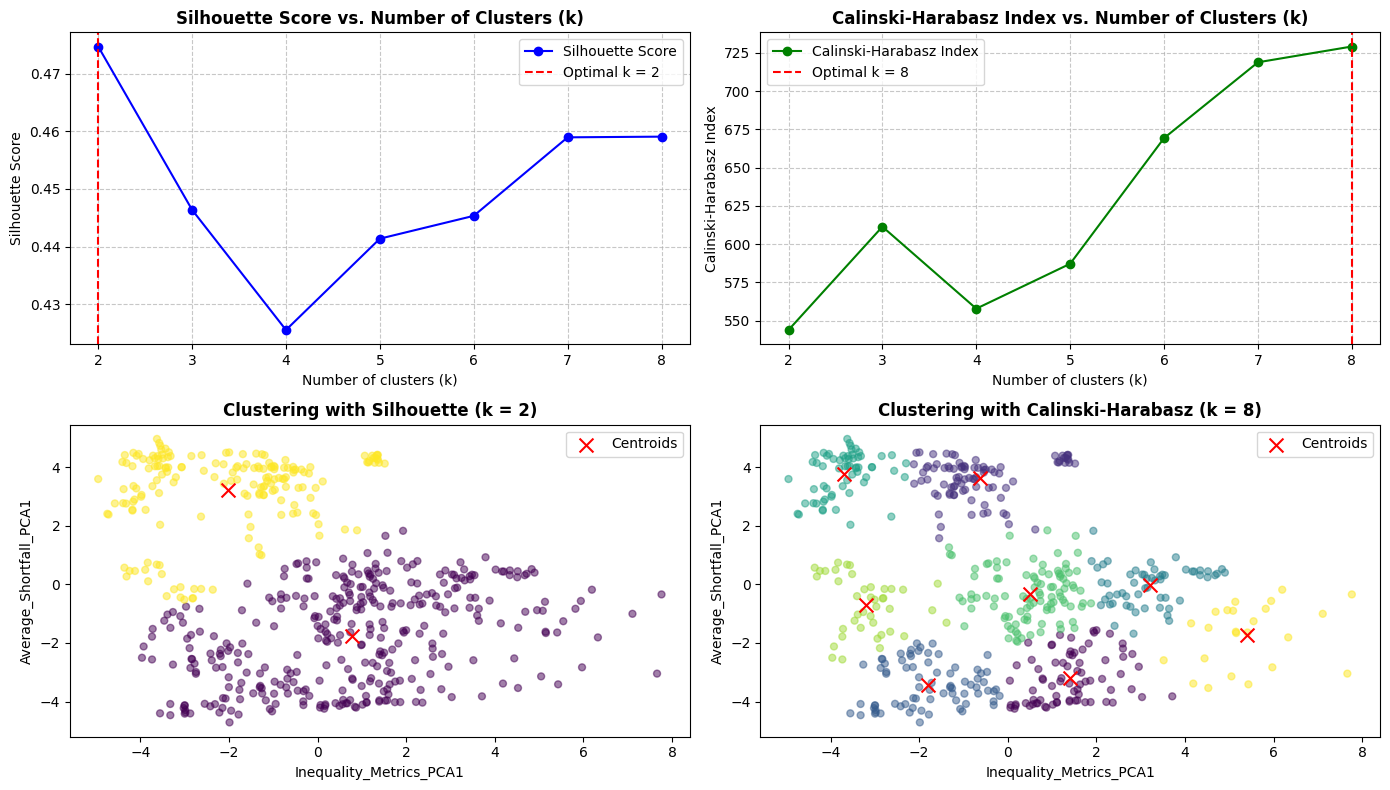

In [293]:
# Loop through each k value and calculate both metrics
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=9)
    labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, labels)) 
    ch_scores.append(calinski_harabasz_score(X, labels))

optimal_k_silhouette = k_values[np.argmax(silhouette_scores)]
optimal_k_ch = k_values[np.argmax(ch_scores)]

# Perform clustering with the optimal k for both methods
kmeans_silhouette = KMeans(n_clusters=optimal_k_silhouette, random_state=0, n_init=9)
labels_silhouette = kmeans_silhouette.fit_predict(X)
kmeans_ch = KMeans(n_clusters=optimal_k_ch, random_state=0, n_init=9)
labels_ch = kmeans_ch.fit_predict(X)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Plot Silhouette Score vs. k
axes[0, 0].plot(k_values, silhouette_scores, marker='o', linestyle='-', color='blue', label='Silhouette Score')
axes[0, 0].axvline(optimal_k_silhouette, color='red', linestyle='--', label=f'Optimal k = {optimal_k_silhouette}')
axes[0, 0].set_title("Silhouette Score vs. Number of Clusters (k)", fontdict={'fontsize': 12, 'weight': 'bold'})
axes[0, 0].set_xlabel("Number of clusters (k)")
axes[0, 0].set_ylabel("Silhouette Score")
axes[0, 0].legend()
axes[0, 0].grid(True, linestyle='--', alpha=0.7)

# Scatter plot for Silhouette optimal clustering
axes[1, 0].scatter(X[var1_clustering], X[var2_clustering], c=labels_silhouette, cmap='viridis', s=25, alpha=0.5)
axes[1, 0].scatter(kmeans_silhouette.cluster_centers_[:, 0], kmeans_silhouette.cluster_centers_[:, 1], c='red', marker='x', s=100, label='Centroids')
axes[1, 0].set_title(f"Clustering with Silhouette (k = {optimal_k_silhouette})", fontdict={'fontsize': 12, 'weight': 'bold'})
axes[1, 0].set_xlabel(var1_clustering)
axes[1, 0].set_ylabel(var2_clustering)
axes[1, 0].legend()

# Plot Calinski-Harabasz Index vs. k
axes[0, 1].plot(k_values, ch_scores, marker='o', linestyle='-', color='green', label='Calinski-Harabasz Index')
axes[0, 1].axvline(optimal_k_ch, color='red', linestyle='--', label=f'Optimal k = {optimal_k_ch}')
axes[0, 1].set_title("Calinski-Harabasz Index vs. Number of Clusters (k)", fontdict={'fontsize': 12, 'weight': 'bold'})
axes[0, 1].set_xlabel("Number of clusters (k)")
axes[0, 1].set_ylabel("Calinski-Harabasz Index")
axes[0, 1].legend()
axes[0, 1].grid(True, linestyle='--', alpha=0.7)

# Scatter plot for Calinski-Harabasz optimal clustering
axes[1, 1].scatter(X[var1_clustering], X[var2_clustering], c=labels_ch, cmap='viridis', s=25, alpha=0.5)
axes[1, 1].scatter(kmeans_ch.cluster_centers_[:, 0], kmeans_ch.cluster_centers_[:, 1], c='red', marker='x', s=100, label='Centroids')
axes[1, 1].set_title(f"Clustering with Calinski-Harabasz (k = {optimal_k_ch})", fontdict={'fontsize': 12, 'weight': 'bold'})
axes[1, 1].set_xlabel(var1_clustering)
axes[1, 1].set_ylabel(var2_clustering)
axes[1, 1].legend()

plt.tight_layout()
plt.show()


Probamos también con los métodos Davies-Bouldin Index y el método del codo (Elbow Method).
- **Davies-Bouldin Index**: mide la calidad del clustering comparando  la dispersión interna de los clusters y la distancia entre ellos. Valores más bajos indican una mejor separación entre clusters y una menor dispersión dentro de cada cluster. Útil cuando los clusters no están claramente separados.
- **Elbow Method**: evalúa el clustering observando la inercia, que mide la suma de las distancias cuadradas de los puntos al centroide del cluster. El número óptimo de clusters se identifica en el "codo" del gráfico, donde la inercia comienza a reducirse significativamente. Método visual y eficiente computacionalmente.

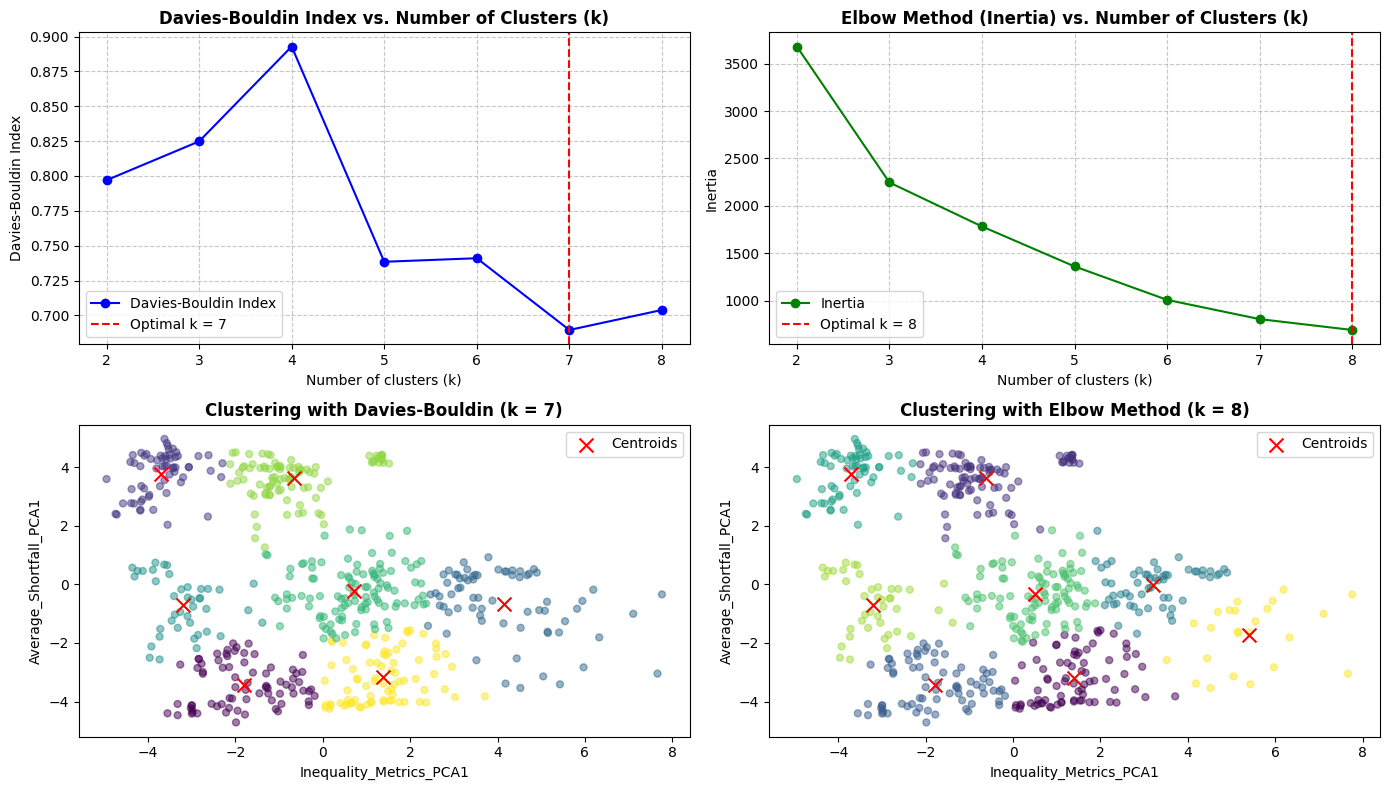

In [294]:
db_scores = []
inertia = []

# Loop through each k value and calculate both metrics hola
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=9)
    labels = kmeans.fit_predict(X)
    
    db_scores.append(davies_bouldin_score(X, labels))
    inertia.append(kmeans.inertia_)

# Find the optimal k for both methods
optimal_k_db = k_values[np.argmin(db_scores)]  # Menor DB
optimal_k_elbow = k_values[np.argmin(np.gradient(np.gradient(inertia)))]  # Codo

# Perform clustering with the optimal k for both methods
kmeans_db = KMeans(n_clusters=optimal_k_db, random_state=0, n_init=9)
labels_db = kmeans_db.fit_predict(X)
kmeans_elbow = KMeans(n_clusters=optimal_k_elbow, random_state=0, n_init=9)
labels_elbow = kmeans_elbow.fit_predict(X)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Plot Davies-Bouldin Index vs. k
axes[0, 0].plot(k_values, db_scores, marker='o', linestyle='-', color='blue', label='Davies-Bouldin Index')
axes[0, 0].axvline(optimal_k_db, color='red', linestyle='--', label=f'Optimal k = {optimal_k_db}')
axes[0, 0].set_title("Davies-Bouldin Index vs. Number of Clusters (k)", fontdict={'fontsize': 12, 'weight': 'bold'})
axes[0, 0].set_xlabel("Number of clusters (k)")
axes[0, 0].set_ylabel("Davies-Bouldin Index")
axes[0, 0].legend()
axes[0, 0].grid(True, linestyle='--', alpha=0.7)

# Scatter plot for Davies-Bouldin optimal clustering
axes[1, 0].scatter(X[var1_clustering], X[var2_clustering], c=labels_db, cmap='viridis', s=25, alpha=0.5)
axes[1, 0].scatter(kmeans_db.cluster_centers_[:, 0], kmeans_db.cluster_centers_[:, 1], c='red', marker='x', s=100, label='Centroids')
axes[1, 0].set_title(f"Clustering with Davies-Bouldin (k = {optimal_k_db})", fontdict={'fontsize': 12, 'weight': 'bold'})
axes[1, 0].set_xlabel(var1_clustering)
axes[1, 0].set_ylabel(var2_clustering)
axes[1, 0].legend()

# Plot Elbow Method (Inertia) vs. k
axes[0, 1].plot(k_values, inertia, marker='o', linestyle='-', color='green', label='Inertia')
axes[0, 1].axvline(optimal_k_elbow, color='red', linestyle='--', label=f'Optimal k = {optimal_k_elbow}')
axes[0, 1].set_title("Elbow Method (Inertia) vs. Number of Clusters (k)", fontdict={'fontsize': 12, 'weight': 'bold'})
axes[0, 1].set_xlabel("Number of clusters (k)")
axes[0, 1].set_ylabel("Inertia")
axes[0, 1].legend()
axes[0, 1].grid(True, linestyle='--', alpha=0.7)

# Scatter plot for Elbow optimal clustering
axes[1, 1].scatter(X[var1_clustering], X[var2_clustering], c=labels_elbow, cmap='viridis', s=25, alpha=0.5)
axes[1, 1].scatter(kmeans_elbow.cluster_centers_[:, 0], kmeans_elbow.cluster_centers_[:, 1], c='red', marker='x', s=100, label='Centroids')
axes[1, 1].set_title(f"Clustering with Elbow Method (k = {optimal_k_elbow})", fontdict={'fontsize': 12, 'weight': 'bold'})
axes[1, 1].set_xlabel(var1_clustering)
axes[1, 1].set_ylabel(var2_clustering)
axes[1, 1].legend()

plt.tight_layout()
plt.show()


In [295]:
# Clustering method
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=9)

C:\Users\carlo\AppData\Local\Temp\ipykernel_26856\3226585491.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_continent = X[dataset_PCA['continent'] == continent]
C:\Users\carlo\AppData\Local\Temp\ipykernel_26856\3226585491.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_continent = X[dataset_PCA['continent'] == continent]
C:\Users\carlo\AppData\Local\Temp\ipykernel_26856\3226585491.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_continent = X[dataset_PCA['continent'] == continent]
C:\Users\carlo\AppData\Local\Temp\ipykernel_26856\3226585491.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_continent = X[dataset_PCA['continent'] == continent]
C:\Users\carlo\AppData\Local\Temp\ipykernel_26856\3226585491.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_continent = X[dataset_PCA['continent'] == continent]


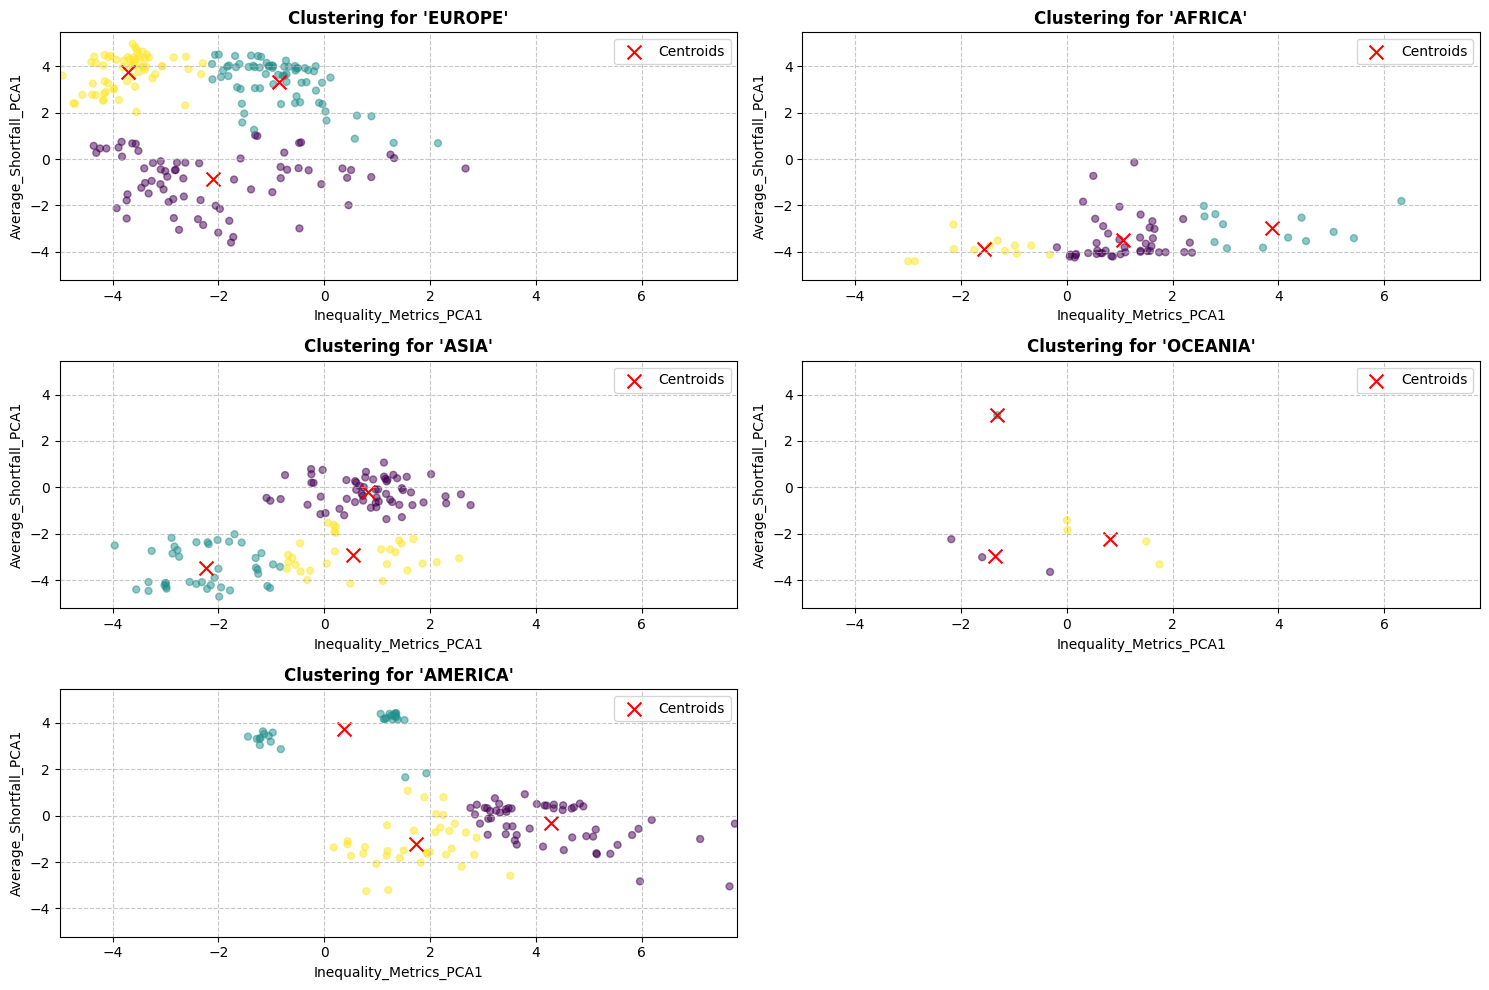

In [296]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()
continents = dataset_PCA['continent'].unique()
num_continents = len(continents)

# Loop through each continent and plot in the subplots
for i, continent in enumerate(continents):
    # Filter the data for the current continent and cluster
    X_continent = X[dataset_PCA['continent'] == continent]
    X_continent = X_continent.reset_index(drop=True)
    # X_continent['Cluster'] = kmeans.fit_predict(X_continent)
    X_continent['Cluster'] = kmeans.fit_predict(X_continent[[var1_clustering, var2_clustering]])
    
    # Plot on the corresponding subplot
    ax = axes[i]
    scatter = ax.scatter(X_continent[var1_clustering], X_continent[var2_clustering], c=X_continent['Cluster'], cmap='viridis', s=25, alpha=0.5)
    ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100, label='Centroids')
    ax.set_title(f"Clustering for '{continent.upper()}'", fontdict={'weight': 'bold', 'size': 12})
    ax.set_xlabel(var1_clustering)
    ax.set_ylabel(var2_clustering)
    ax.set_xlim(var1_min-0.05, var1_max+0.05)
    ax.set_ylim(var2_min-0.5, var2_max+0.5)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()

# Remove empty subplots if there are fewer continents
if num_continents < len(axes):
    for j in range(num_continents, len(axes)):
        fig.delaxes(axes[j])

fig.tight_layout()
plt.show()


C:\Users\carlo\AppData\Local\Temp\ipykernel_26856\2111618398.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_welfare = X[dataset_PCA['welfare_type'] == welfare]
C:\Users\carlo\AppData\Local\Temp\ipykernel_26856\2111618398.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_welfare = X[dataset_PCA['welfare_type'] == welfare]


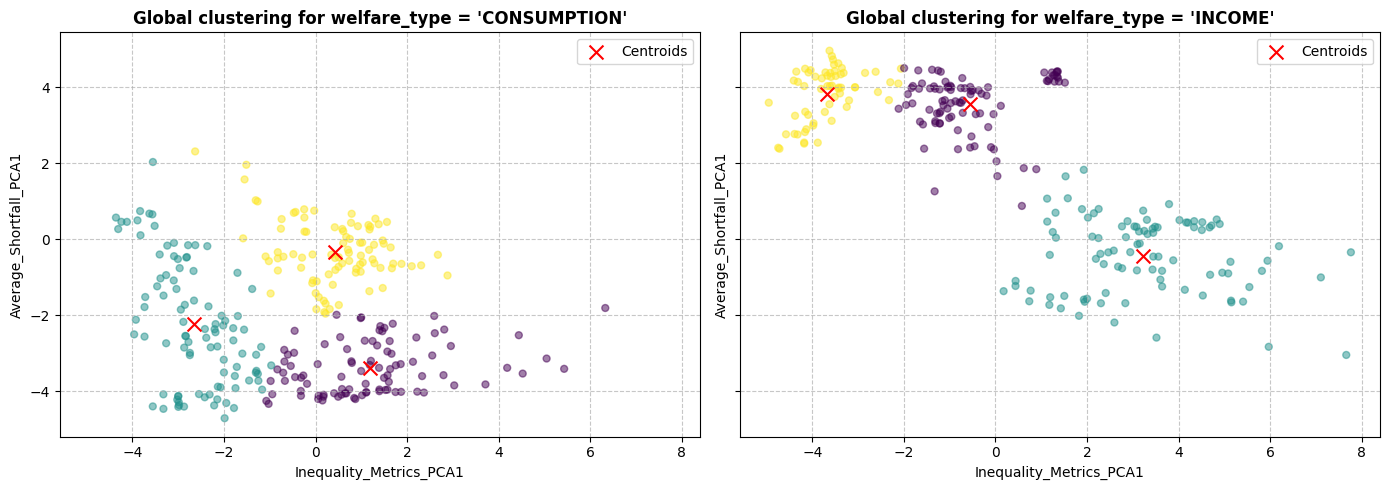

In [297]:
# Create a figure with two subplots for each welfare type
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

for ax, welfare in zip(axes, dataset_PCA['welfare_type'].unique()):
    # Filter the data for the current welfare type
    X_welfare = X[dataset_PCA['welfare_type'] == welfare]
    X_welfare = X_welfare.reset_index(drop=True)

    # X_welfare['Cluster'] = kmeans.fit_predict(X_welfare)
    X_welfare['Cluster'] = kmeans.fit_predict(X_welfare[[var1_clustering, var2_clustering]])


    # Scatter plot for the current welfare type
    scatter = ax.scatter(X_welfare[var1_clustering],X_welfare[var2_clustering], c=X_welfare['Cluster'], cmap='viridis', s=25, alpha=0.5)
    ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100, label='Centroids')
    ax.set_title(f"Global clustering for welfare_type = '{welfare.upper()}'", fontdict={'fontsize': 12, 'weight': 'bold'})
    ax.set_xlabel(var1_clustering)
    ax.set_ylabel(var2_clustering)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicates
    ax.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()


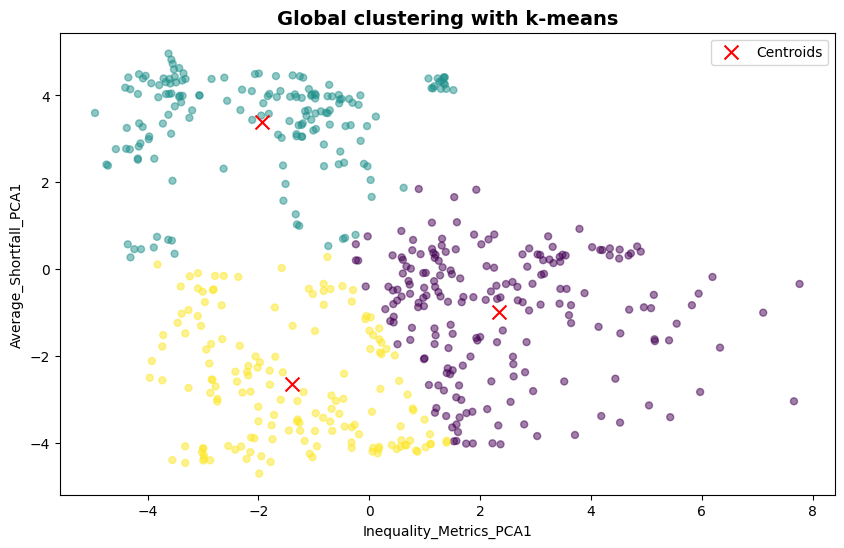

In [298]:
# X['Cluster'] = kmeans.fit_predict(X[[var1_clustering, var2_clustering]])  
X['Cluster'] = kmeans.fit_predict(X)  

# Scatter plot of the results after clustering
plt.figure(figsize=(10, 6))
plt.scatter(X[var1_clustering], X[var2_clustering], c=X['Cluster'], cmap='viridis', s=25, alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100, label='Centroids')
plt.title("Global clustering with k-means", fontdict={'fontsize': 14, 'weight': 'bold'})
plt.xlabel(var1_clustering)
plt.ylabel(var2_clustering)
ax.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

### KK (ANÁLISIS GLOBAL)

In [299]:
# feat_names = data.columns
# feat_cat = list(feat_names[0:2]) + list(feat_names[3:5])
# feat_num = [feat for feat in feat_names if feat not in feat_cat]
# dataset = data[feat_num]
# dataset = dataset.iloc[:, :-8]
# dataset

ANÁLISIS GLOBAL DE CORRELACIONES + PCA

In [300]:

# ## CORRELATION MATRIX HEAT MAP
# corr_num = dataset.corr()
# mask = np.triu(np.ones_like(corr_num, dtype=bool)) # A mask to hide the upper right part of the matrix (it is duplicated)

# plt.figure(figsize=(18, 10))  # Aumenta el tamaño del gráfico para acomodar más etiquetas
# sns.heatmap(corr_num.iloc[1:, :-1], mask=mask[1:, :-1], annot=False, fmt=".2f", cmap="cividis", annot_kws={"size": 5})
# plt.title('Correlation Matrix Heat Map', fontdict={'fontsize': 12, 'weight': 'bold'})
# plt.xticks(rotation=90, fontsize=10)  
# plt.yticks(fontsize=10)  
# plt.show()

# ## PCA & PARETO CHART
# # Standarise using Z-score
# scaler = StandardScaler()
# data_standardized = scaler.fit_transform(dataset)

# pca = PCA()
# pca_data = pca.fit_transform(data_standardized)
# explained_variance = pca.explained_variance_ratio_

# # Select the first N components
# n_components = 12
# explained_variance_N = explained_variance[:n_components]
# cumulative_variance_N = np.cumsum(explained_variance_N)

# # Pareto Chart
# plt.figure(figsize=(8, 6))
# components = np.arange(1, n_components+1)

# # Explained and cumulative variance
# plt.bar(components, explained_variance_N, color='lightblue', label="Explained Variance")
# plt.plot(components, cumulative_variance_N, marker='o', color='r', label="Cumulative Variance")

# plt.xlabel("Principal Components")
# plt.ylabel("Proportion of Explained Variance")
# plt.title(f'Pareto Chart of the First {n_components} Principal Components', fontdict={'fontsize': 14, 'weight': 'bold'})

# # Alabels with the percentage variability
# for i in range(len(components)):
#     plt.text(components[i], explained_variance_N[i] + 0.01, f"{explained_variance_N[i]:.2%}", ha='center', va='bottom', fontsize=10)

# plt.xticks(components)
# plt.legend(loc='upper left')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.gca().yaxis.set_major_locator(MultipleLocator(0.1))  # Set grid lines every 0.1 on the y-axis
# plt.show()

# # Select and store the minimum number of components needed to reach 90% cumulative variance
# n_components_90 = np.argmax(np.round(cumulative_variance_N, 2) >= 0.90) + 1  # Number of components needed for 90%
# pca_columns = [f"PCA_{i+1}" for i in range(n_components_90)]
# dataset_PCA_subset = pd.DataFrame(pca_data[:, :n_components_90], columns=pca_columns)
# dataset_PCA = pd.concat([dataset_PCA, dataset_PCA_subset], axis=1)

In [301]:
# # Prepare environment
# var1_clustering = 'PCA_1'
# var2_clustering = 'PCA_2'

# X = dataset_PCA.iloc[:, 7:]

# # Calculate the global min and max for the variables
# var1_min, var1_max = X[var1_clustering].min(), X[var1_clustering].max()
# var2_min, var2_max = X[var2_clustering].min(), X[var2_clustering].max()

# k_values = range(2, 9)
# silhouette_scores = []
# ch_scores = []

In [302]:
# # Create a figure with two subplots for each welfare type
# fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

# for ax, welfare in zip(axes, dataset_PCA['welfare_type'].unique()):
#     # Filter the data for the current welfare type
#     X_welfare = X[dataset_PCA['welfare_type'] == welfare]
#     X_welfare = X_welfare.reset_index(drop=True)

#     # X_welfare['Cluster'] = kmeans.fit_predict(X_welfare)
#     X_welfare['Cluster'] = kmeans.fit_predict(X_welfare[[var1_clustering, var2_clustering]])


#     # Scatter plot for the current welfare type
#     scatter = ax.scatter(X_welfare[var1_clustering],X_welfare[var2_clustering], c=X_welfare['Cluster'], cmap='viridis', s=25, alpha=0.5)
#     ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100, label='Centroids')
#     ax.set_title(f"Global clustering for welfare_type = '{welfare.upper()}'", fontdict={'fontsize': 12, 'weight': 'bold'})
#     ax.set_xlabel(var1_clustering)
#     ax.set_ylabel(var2_clustering)
#     ax.grid(True, linestyle='--', alpha=0.7)
    
#     handles, labels = ax.get_legend_handles_labels()
#     by_label = dict(zip(labels, handles))  # Remove duplicates
#     ax.legend(by_label.values(), by_label.keys())

# plt.tight_layout()
# plt.show()
